This notebook is best viewed here: http://nbviewer.jupyter.org 

# rewrite this for jack pine

#### Purpose
    - This notebook runs RDA on the Doug-fir SNP data for coastal variety to isolate genotype-environment associations

#### Notebook Outline
    
- __Prepare data__
    - Because RDA requires no missing data, I first use python to isolate coastal loci with no missing data.
    - To include more loci, for any population that has missing data at a locus, I impute by taking the average frequency of the four most geographically proximal populations using Vincenty distance.
        
- __Run RDA__
    - I then switch to R to use the package `vegan` to run RDA

#############################################################################################################################
# <center> python
#############################################################################################################################

# prepare data

In [1]:
from pythonimports import *
from vincenty import vincenty
from tqdm import tqdm

lview,dview = get_client()

56 56


In [2]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 647abb223c2255e83d2a5fb93a3e0f510c9b2893
Author: Brandon <lindb@vcu.edu>
Date:   Fri Jan 22 16:27:36 2021 -0700
Today:	January 27, 2021 - 10:36:26
python version: 3.8.5
##################################################################



In [3]:
# variables
rdadir = makedir('/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/rda')
# 03-filtered SNP file
snpfile = op.join(op.dirname(rdadir), 'JP_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt')
# centered/standardized environmental data
envfile = '/data/projects/pool_seq/environemental_data/jp_std_env-19variables.txt'

# files that will be made in scripts below:
# loci with no missing data
nomissingfile = op.join(rdadir, op.basename(snpfile).replace('.txt', '_nomissing-loci-list.txt'))
# imputed loci
imp_pkl = op.join(rdadir, op.basename(snpfile).replace('.txt',  '_IMPUTED_nontransformed.pkl'))  # untransformed (pops as cols)
impfile = op.join(rdadir, op.basename(snpfile).replace('.txt',  '_IMPUTED.txt'))  # transformed (loci as cols)

#### get frequency info for each locus

In [4]:
# determine columns to read in to save time
goodcols = ['unstitched_chrom', 'unstitched_pos', 'unstitched_locus']
cols = !head -1 $snpfile
cols = cols[0].split()
cols = [col for col in cols if col in goodcols or 'FREQ' in col]

# read in the SNPs
snps = parallel_read(snpfile, lview=lview, verbose=False, usecols=cols)
snps.columns = [col if '.' not in col else col.split('.')[0] for col in snps]
snps.index = snps['unstitched_locus'].tolist()

# # convert percentage to float
print('\n')
time.sleep(2)
tqdm.pandas(desc='converting to float')

popcols = [col for col in snps.columns if '_' in col and col not in goodcols]
snps = snps[popcols].progress_apply(lambda freqdata: freqdata.str.replace("%", "").astype(float) / 100, axis=0)
snps.head()


Watching 56 parallel_read() jobs ...


JP_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:13<00:00,  4.25it/s]


Function `parallel_read` completed after : 0-00:00:20




/lu213/brandon.lind/data/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
converting to float: 100%|██████████| 40/40 [00:24<00:00,  1.66it/s]


,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
>super4-15421,0.7273,0.8438,0.7692,0.8571,0.5714,0.6875,0.7692,0.5556,0.7391,0.6250,0.8333,0.8421,0.6667,0.7419,0.5854,0.5000,0.8889,0.6522,0.7500,0.9048,0.7143,0.7273,0.4348,0.7222,0.7000,0.5769,0.7500,0.6000,0.3333,0.5600,0.7407,0.4348,0.6429,0.5714,0.8000,0.5000,0.7857,0.8462,0.4231,0.6316
>super4-47333,0.0820,0.0909,0.2118,0.0000,0.0827,0.1356,0.0543,0.0471,0.0368,0.0792,0.0625,0.0530,0.0865,0.0865,0.1840,0.0746,0.1870,0.0325,0.2000,0.0246,0.1333,0.0394,0.0745,0.1489,0.0263,0.0598,0.0340,0.0256,0.0672,0.0634,0.2538,0.0000,0.2833,0.1981,0.1818,0.0909,0.0550,0.1359,0.0000,0.0857
>super4-47418,0.2000,0.1857,0.2577,0.0710,0.2117,0.2778,0.3434,0.1009,0.2345,0.2553,0.3782,0.3913,0.1959,0.1895,0.1500,0.2267,0.1339,0.3312,0.1064,0.3967,0.1429,0.2993,0.0404,0.1100,0.2785,0.1844,0.2727,0.1529,0.4962,0.3077,0.3200,0.1571,0.0588,0.2000,0.1591,0.1798,0.1964,0.2157,0.0992,0.1721
>super4-47461,0.0000,0.0000,0.0485,0.4099,0.0750,0.1652,0.0619,0.0550,0.0709,0.0208,0.0897,0.1515,0.0964,0.0506,0.1092,0.1316,0.0165,0.1905,0.0118,0.0172,0.0357,0.1678,0.0698,0.0306,0.1519,0.0993,0.1176,0.0602,0.1119,0.0606,0.1034,0.0847,0.0000,0.0606,0.0000,0.1190,0.0196,0.0220,0.1951,0.1920
>super4-47513,0.5584,0.5639,0.3918,0.1190,0.5000,0.3478,0.5243,0.7071,0.5662,0.6321,0.4841,0.3407,0.4500,0.6800,0.4194,0.5634,0.6512,0.3600,0.5577,0.5000,0.5802,0.4710,0.6364,0.7347,0.4762,0.5359,0.5755,0.6024,0.3277,0.4730,0.2846,0.6462,0.6418,0.5400,0.6304,0.4699,0.4914,0.5556,0.6978,0.4917


#### save no missing data

In [5]:
tqdm.pandas(desc="remove missing data!")

/lu213/brandon.lind/data/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [6]:
# get loci with no missing data
nomissingloci = snps[snps.progress_apply(lambda x: sum([val!=val for val in x])==0, axis=1)]
nomissingloci.head()

remove missing data!: 100%|██████████| 1235752/1235752 [00:16<00:00, 74364.72it/s]


,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
>super4-15421,0.7273,0.8438,0.7692,0.8571,0.5714,0.6875,0.7692,0.5556,0.7391,0.6250,0.8333,0.8421,0.6667,0.7419,0.5854,0.5000,0.8889,0.6522,0.7500,0.9048,0.7143,0.7273,0.4348,0.7222,0.7000,0.5769,0.7500,0.6000,0.3333,0.5600,0.7407,0.4348,0.6429,0.5714,0.8000,0.5000,0.7857,0.8462,0.4231,0.6316
>super4-47333,0.0820,0.0909,0.2118,0.0000,0.0827,0.1356,0.0543,0.0471,0.0368,0.0792,0.0625,0.0530,0.0865,0.0865,0.1840,0.0746,0.1870,0.0325,0.2000,0.0246,0.1333,0.0394,0.0745,0.1489,0.0263,0.0598,0.0340,0.0256,0.0672,0.0634,0.2538,0.0000,0.2833,0.1981,0.1818,0.0909,0.0550,0.1359,0.0000,0.0857
>super4-47418,0.2000,0.1857,0.2577,0.0710,0.2117,0.2778,0.3434,0.1009,0.2345,0.2553,0.3782,0.3913,0.1959,0.1895,0.1500,0.2267,0.1339,0.3312,0.1064,0.3967,0.1429,0.2993,0.0404,0.1100,0.2785,0.1844,0.2727,0.1529,0.4962,0.3077,0.3200,0.1571,0.0588,0.2000,0.1591,0.1798,0.1964,0.2157,0.0992,0.1721
>super4-47461,0.0000,0.0000,0.0485,0.4099,0.0750,0.1652,0.0619,0.0550,0.0709,0.0208,0.0897,0.1515,0.0964,0.0506,0.1092,0.1316,0.0165,0.1905,0.0118,0.0172,0.0357,0.1678,0.0698,0.0306,0.1519,0.0993,0.1176,0.0602,0.1119,0.0606,0.1034,0.0847,0.0000,0.0606,0.0000,0.1190,0.0196,0.0220,0.1951,0.1920
>super4-47513,0.5584,0.5639,0.3918,0.1190,0.5000,0.3478,0.5243,0.7071,0.5662,0.6321,0.4841,0.3407,0.4500,0.6800,0.4194,0.5634,0.6512,0.3600,0.5577,0.5000,0.5802,0.4710,0.6364,0.7347,0.4762,0.5359,0.5755,0.6024,0.3277,0.4730,0.2846,0.6462,0.6418,0.5400,0.6304,0.4699,0.4914,0.5556,0.6978,0.4917


In [7]:
nomissingloci.isna().sum().sum()

0

In [8]:
# save
nomissingdf = pd.DataFrame(nomissingloci.index.tolist(), columns=['no_missing_loci'])
nomissingdf.to_csv(nomissingfile, sep='\t', index=False)

#### calc Vincenty distances between all pops so I can use to impute missing data using most proximal pops

In [10]:
# load environmental data
envdata = pd.read_table(envfile)
envdata.head()

,id1,id2,our_id,Latitude,Longitude,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
0,9150251,38,JP_p98,54.3333,-106.6333,537,0.702161,0.550687,-0.923679,1.114516,-1.002217,-0.420495,-0.756992,-0.899318,-1.151749,-1.104016,-1.005158,-1.153526,-0.886605,0.027197,-0.899267,0.795876,0.822560,0.304423,-1.205351
1,3273,22,JP_p73,44.4200,-84.6800,359,0.861856,1.380348,1.500889,-1.335983,1.470853,0.696905,1.922962,1.056481,-0.138853,1.486412,1.414019,-0.056960,1.214977,0.923098,-0.803992,0.339162,-1.165432,-0.735070,1.016494
2,8060006,37,JP_p97,56.1167,-116.9167,636,1.161285,1.394176,-1.225419,0.745700,-0.648921,-0.361685,-0.477565,-1.807367,-1.260140,-0.939544,-0.945179,-1.555599,-1.674698,-0.676726,-0.864621,1.013853,0.465168,0.749920,-2.316274
3,3260,17,JP_p60,46.7200,-84.3900,203,-0.236050,-0.085386,0.084487,-0.837726,0.909736,-0.655738,0.068586,0.497681,0.294712,0.622936,0.874203,-0.032592,-0.229861,0.475148,0.278680,-0.262870,-1.053748,0.155924,1.016494
4,9040116,40,JP_p100,55.7667,-97.8167,205,-0.874832,-0.154524,-1.882146,2.424876,-1.771154,-0.126443,-1.849295,-2.366167,-0.983556,-2.378670,-1.964832,-1.031685,-1.477675,-2.724500,-0.362262,0.328782,1.693702,2.531907,-1.871904


In [12]:
# fill out symmetric distance matrix
distances = OrderedDict()
for i,popi in enumerate(envdata['our_id']):
    icoords = (envdata.loc[i, 'Latitude'], envdata.loc[i, 'Longitude'])
    distances[popi] = OrderedDict()
    for j,popj in enumerate(envdata['our_id']):
        if popj not in distances:
            distances[popj] = OrderedDict()
        jcoords = (envdata.loc[j, 'Latitude'], envdata.loc[j, 'Longitude'])
        dist = vincenty(icoords, jcoords)
        distances[popi][popj] = dist
distdf = pd.DataFrame(distances)
distdf.head()

,JP_p98,JP_p73,JP_p97,JP_p60,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p102
JP_p98,0.000000,1925.327040,683.095038,1779.456365,585.206029,2324.659369,140.476152,2315.356188,1309.463509,2464.503464,826.677014,2790.218015,2873.817416,1547.181689,3074.531966,447.179342,2067.704291,327.046117,2277.716318,920.298977,2761.026874,1682.220917,3162.335323,124.789832,1874.382431,275.290520,1948.827086,718.275104,2322.222241,488.715069,2338.832713,1034.799868,2547.433546,972.166133,2635.201788,2646.546070,1497.024739,3322.353631,48.922970,101.831086
JP_p73,1925.327040,0.000000,2606.606459,256.628558,1568.094054,622.379879,1835.040993,733.119798,660.668799,1090.340973,1098.690185,1073.878418,1430.285763,420.193050,1560.877982,2339.795281,267.646791,1673.083555,819.130456,1012.722442,1141.599412,351.457611,1646.383793,2034.925324,56.069257,2189.749539,469.962727,1255.497047,540.662212,1437.433284,1030.392744,892.634319,971.415162,953.240181,1177.825726,1367.104669,587.821269,1908.496731,1950.004814,1877.714940
JP_p97,683.095038,2606.606459,0.000000,2462.306718,1190.316675,3002.067764,775.294552,2986.003946,1979.906031,3112.164739,1508.185214,3462.495695,3515.643750,2221.483197,3720.261223,364.705862,2750.548069,976.794284,2940.473228,1597.103405,3425.108916,2352.652132,3806.455651,584.167366,2555.101569,418.377781,2625.199179,1375.956101,3003.023150,1169.219524,2985.040783,1717.553343,3211.993106,1653.499397,3285.790984,3275.210069,2174.361793,3947.895518,656.602730,744.847021
JP_p60,1779.456365,256.628558,2462.306718,0.000000,1370.854339,591.317372,1702.808436,650.176330,619.873079,964.102868,964.279904,1073.526592,1343.536829,433.117203,1500.076373,2174.753821,288.248246,1504.166380,695.384109,899.556459,1101.494716,451.706976,1589.033391,1881.750490,249.656403,2050.667923,293.878783,1156.740852,556.421841,1299.908444,880.974322,750.933483,904.955447,823.558496,1082.450109,1233.971958,346.822072,1830.211728,1808.849744,1721.797208
JP_p100,585.206029,1568.094054,1190.316675,1370.854339,0.000000,1854.018558,610.601379,1819.088309,1074.086729,1923.135076,591.122701,2295.825460,2325.392034,1266.391979,2530.357575,850.907061,1650.416475,266.892530,1761.800064,711.166657,2245.869721,1412.728577,2616.319531,629.693995,1525.473205,838.147273,1478.433993,682.792288,1872.927012,446.662162,1795.769987,723.221446,2034.134162,702.250247,2097.497580,2086.067126,1043.140018,2760.069636,632.584485,487.848013


In [13]:
# make sure distance to self is 0
for pop in distdf.columns:
    assert distdf.loc[pop,pop] == 0

#### calculate mean of four nearest pops

In [14]:
def impute_freq(freqdata, focalpop):
    """Get the mean freq for the four closest populations to `focalpop`.
    
    Parameters
    ----------
    freqdata - list of ALT allele freqs for all pops from a given locus, some are np.nan
    closest - allele freqs in order of population proximity to `focalpop`
    """
    import numpy
    # re-sort freqdata by distance to focalpop
    closest = freqdata.reindex(distdf[focalpop].sort_values(ascending=True).index.tolist()).copy()
    
    nums = []
    for pop,freq in closest.items():
        if pop == focalpop:
            # ignore focal pop since this will be first in the list
            continue
        if freq==freq:  # if it is not NA
            nums.append(freq)
        if len(nums) == 4:
            break

    return numpy.mean(nums)

dview['impute_freq'] = impute_freq
dview['distdf'] = distdf

In [15]:
def impute(loci):
    """For each locus in loci, identify pops with missing data and impute with `impute_freq()`.
    
    Parameters
    ----------
    freqdata - list of ALT allele freqs for a given locus, some are np.nan
    """
    import pandas
    import tqdm

    frames = []
    for locus in tqdm.tqdm(loci, desc='imputing'):
        freqdata = snps.loc[locus, popcols].copy()
        for pop,freq in freqdata.items():
            if freq != freq:  # if np.nan
                freqdata[pop] = impute_freq(freqdata, pop)
        frames.append(pandas.DataFrame(freqdata).T)

    return pandas.concat(frames)

dview['impute'] = impute
dview['snps'] = snps[popcols]
dview['popcols'] = popcols

In [16]:
smallimpute = impute(snps.index.tolist()[:5])
smallimpute

imputing: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s]


,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
>super4-15421,0.7273,0.8438,0.7692,0.8571,0.5714,0.6875,0.7692,0.5556,0.7391,0.6250,0.8333,0.8421,0.6667,0.7419,0.5854,0.5000,0.8889,0.6522,0.7500,0.9048,0.7143,0.7273,0.4348,0.7222,0.7000,0.5769,0.7500,0.6000,0.3333,0.5600,0.7407,0.4348,0.6429,0.5714,0.8000,0.5000,0.7857,0.8462,0.4231,0.6316
>super4-47333,0.0820,0.0909,0.2118,0.0000,0.0827,0.1356,0.0543,0.0471,0.0368,0.0792,0.0625,0.0530,0.0865,0.0865,0.1840,0.0746,0.1870,0.0325,0.2000,0.0246,0.1333,0.0394,0.0745,0.1489,0.0263,0.0598,0.0340,0.0256,0.0672,0.0634,0.2538,0.0000,0.2833,0.1981,0.1818,0.0909,0.0550,0.1359,0.0000,0.0857
>super4-47418,0.2000,0.1857,0.2577,0.0710,0.2117,0.2778,0.3434,0.1009,0.2345,0.2553,0.3782,0.3913,0.1959,0.1895,0.1500,0.2267,0.1339,0.3312,0.1064,0.3967,0.1429,0.2993,0.0404,0.1100,0.2785,0.1844,0.2727,0.1529,0.4962,0.3077,0.3200,0.1571,0.0588,0.2000,0.1591,0.1798,0.1964,0.2157,0.0992,0.1721
>super4-47461,0.0000,0.0000,0.0485,0.4099,0.0750,0.1652,0.0619,0.0550,0.0709,0.0208,0.0897,0.1515,0.0964,0.0506,0.1092,0.1316,0.0165,0.1905,0.0118,0.0172,0.0357,0.1678,0.0698,0.0306,0.1519,0.0993,0.1176,0.0602,0.1119,0.0606,0.1034,0.0847,0.0000,0.0606,0.0000,0.1190,0.0196,0.0220,0.1951,0.1920
>super4-47513,0.5584,0.5639,0.3918,0.1190,0.5000,0.3478,0.5243,0.7071,0.5662,0.6321,0.4841,0.3407,0.4500,0.6800,0.4194,0.5634,0.6512,0.3600,0.5577,0.5000,0.5802,0.4710,0.6364,0.7347,0.4762,0.5359,0.5755,0.6024,0.3277,0.4730,0.2846,0.6462,0.6418,0.5400,0.6304,0.4699,0.4914,0.5556,0.6978,0.4917


In [17]:
# iterate snps df so I know none of the previous values were replaced
smallsnps = snps[popcols].head(5).copy()
for pop in nb(smallsnps.columns):
    # assert that only the previously null cells were changed
    assert sum(smallsnps[pop].isnull()) == sum(smallsnps[pop] != smallimpute[pop])

100%|██████████| 40/40 [00:00<00:00, 2767.42it/s]


In [18]:
# calc mean freq of four closest pops in parallel
thresh = math.ceil(nrow(snps) / len(lview))
jobs = []
loci = []
for i,locus in enumerate(nb(snps.index)):
    loci.append(locus)
    if len(loci) == thresh or (i+1) == nrow(snps):
        jobs.append(lview.apply_async(impute, loci))
        loci = []
watch_async(jobs)

100%|██████████| 1235752/1235752 [00:02<00:00, 422693.14it/s]



Watching 56 jobs ...


100%|██████████| 56/56 [01:01<00:00,  1.10s/it]


In [19]:
# gather returns and put into dataframe
frames = []
for i,j in enumerate(nb(jobs)):
    frames.append(j.r)
imputed_snps = pd.concat(frames)

100%|██████████| 56/56 [00:00<00:00, 192367.75it/s]


In [20]:
imputed_snps.head()

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
>super4-15421,0.7273,0.8438,0.7692,0.8571,0.5714,0.6875,0.7692,0.5556,0.7391,0.6250,0.8333,0.8421,0.6667,0.7419,0.5854,0.5000,0.8889,0.6522,0.7500,0.9048,0.7143,0.7273,0.4348,0.7222,0.7000,0.5769,0.7500,0.6000,0.3333,0.5600,0.7407,0.4348,0.6429,0.5714,0.8000,0.5000,0.7857,0.8462,0.4231,0.6316
>super4-47333,0.0820,0.0909,0.2118,0.0000,0.0827,0.1356,0.0543,0.0471,0.0368,0.0792,0.0625,0.0530,0.0865,0.0865,0.1840,0.0746,0.1870,0.0325,0.2000,0.0246,0.1333,0.0394,0.0745,0.1489,0.0263,0.0598,0.0340,0.0256,0.0672,0.0634,0.2538,0.0000,0.2833,0.1981,0.1818,0.0909,0.0550,0.1359,0.0000,0.0857
>super4-47418,0.2000,0.1857,0.2577,0.0710,0.2117,0.2778,0.3434,0.1009,0.2345,0.2553,0.3782,0.3913,0.1959,0.1895,0.1500,0.2267,0.1339,0.3312,0.1064,0.3967,0.1429,0.2993,0.0404,0.1100,0.2785,0.1844,0.2727,0.1529,0.4962,0.3077,0.3200,0.1571,0.0588,0.2000,0.1591,0.1798,0.1964,0.2157,0.0992,0.1721
>super4-47461,0.0000,0.0000,0.0485,0.4099,0.0750,0.1652,0.0619,0.0550,0.0709,0.0208,0.0897,0.1515,0.0964,0.0506,0.1092,0.1316,0.0165,0.1905,0.0118,0.0172,0.0357,0.1678,0.0698,0.0306,0.1519,0.0993,0.1176,0.0602,0.1119,0.0606,0.1034,0.0847,0.0000,0.0606,0.0000,0.1190,0.0196,0.0220,0.1951,0.1920
>super4-47513,0.5584,0.5639,0.3918,0.1190,0.5000,0.3478,0.5243,0.7071,0.5662,0.6321,0.4841,0.3407,0.4500,0.6800,0.4194,0.5634,0.6512,0.3600,0.5577,0.5000,0.5802,0.4710,0.6364,0.7347,0.4762,0.5359,0.5755,0.6024,0.3277,0.4730,0.2846,0.6462,0.6418,0.5400,0.6304,0.4699,0.4914,0.5556,0.6978,0.4917


In [21]:
assert nrow(imputed_snps) == nrow(snps)  # double check that same number of snps are in imputed as in unimputed. A: there are!

In [22]:
# assert that there is no missing data
for col in nb(imputed_snps.columns):
    if col not in ['CHROM', 'POS', 'locus']:
        assert imputed_snps[col].isna().sum() == 0

100%|██████████| 40/40 [00:00<00:00, 408.23it/s]


In [23]:
imp_pkl

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/rda/JP_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated_IMPUTED_nontransformed.pkl'

In [24]:
# save for easier loading in python
pkldump(imputed_snps, imp_pkl)

In [25]:
# transpose data for RDA
imputed_snps_T = imputed_snps.T  # transpose for RDA
imputed_snps_T.index.name = 'index'
imputed_snps_T.head()

,>super4-15421,>super4-47333,>super4-47418,>super4-47461,>super4-47513,>super4-47541,>super4-47593,>super4-47619,>super4-47629,>super4-47661,>super4-47776,>super4-47803,>super4-47821,>super4-47839,>super4-47872,>super4-47977,>super4-47993,>super4-48065,>super4-48080,>super4-48094,>super4-48231,>super4-48240,>super4-48256,>super4-48318,>super4-48370,>super4-48395,>super4-48403,>super4-48432,>super4-48441,>super4-48448,>super4-48464,>super4-48682,>super4-48728,>super4-48740,>super4-48743,>super4-48763,>super4-48775,>super4-48777,>super4-48806,>super4-48836,>super4-48856,>super4-48862,>super4-48871,>super4-48890,>super4-48933,>super4-48977,>super4-49096,>super4-49280,>super4-49460,>super4-49591,...,>TRINITY_DN153620_c14_g3_i2-94,>TRINITY_DN153620_c14_g3_i2-114,>TRINITY_DN153620_c14_g3_i2-127,>TRINITY_DN153620_c14_g3_i2-131,>TRINITY_DN153620_c14_g3_i2-140,>TRINITY_DN153620_c14_g3_i2-153,>TRINITY_DN153620_c14_g3_i2-158,>TRINITY_DN153620_c14_g3_i2-161,>TRINITY_DN153620_c14_g3_i2-194,>TRINITY_DN153620_c14_g3_i2-200,>TRINITY_DN153620_c14_g3_i2-203,>TRINITY_DN153620_c14_g3_i2-204,>TRINITY_DN153620_c14_g3_i2-215,>TRINITY_DN153620_c14_g3_i2-251,>TRINITY_DN153620_c14_g3_i2-267,>TRINITY_DN153620_c14_g3_i2-274,>TRINITY_DN153620_c14_g3_i2-291,>TRINITY_DN153620_c14_g3_i2-298,>TRINITY_DN152118_c17_g1_i3-190,>TRINITY_DN152118_c17_g1_i3-210,>TRINITY_DN152118_c17_g1_i3-223,>TRINITY_DN152118_c17_g1_i3-240,>TRINITY_DN152118_c17_g1_i3-241,>TRINITY_DN152721_c19_g3_i1-81,>TRINITY_DN152721_c19_g3_i1-114,>TRINITY_DN152721_c19_g3_i1-130,>TRINITY_DN152721_c19_g3_i1-135,>TRINITY_DN152721_c19_g3_i1-138,>TRINITY_DN152721_c19_g3_i1-150,>TRINITY_DN152721_c19_g3_i1-193,>TRINITY_DN160941_c3_g1_i4-25,>TRINITY_DN160941_c3_g1_i4-38,>TRINITY_DN160941_c3_g1_i4-42,>TRINITY_DN160941_c3_g1_i4-45,>TRINITY_DN160941_c3_g1_i4-55,>TRINITY_DN160941_c3_g1_i4-68,>TRINITY_DN160941_c3_g1_i4-72,>TRINITY_DN160941_c3_g1_i4-73,>TRINITY_DN160941_c3_g1_i4-74,>TRINITY_DN160941_c3_g1_i4-81,>TRINITY_DN160941_c3_g1_i4-96,>TRINITY_DN160941_c3_g1_i4-124,>TRINITY_DN160941_c3_g1_i4-125,>TRINITY_DN160941_c3_g1_i4-126,>TRINITY_DN160941_c3_g1_i4-129,>TRINITY_DN160941_c3_g1_i4-151,>TRINITY_DN160941_c3_g1_i4-166,>TRINITY_DN160941_c3_g1_i4-178,>TRINITY_DN160941_c3_g1_i4-190,>TRINITY_DN152206_c11_g1_i4-119
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
JP_p98,0.7273,0.0820,0.2000,0.0000,0.5584,0.00,0.0125,0.9200,0.9565,0.0000,0.1392,0.0641,0.0602,0.1026,0.0274,0.8542,0.0455,0.8261,0.0870,0.6522,1.0000,1.0000,0.8710,0.8780,0.0200,0.1087,0.2326,0.1957,0.1364,0.7442,0.1579,0.7105,0.6585,0.0233,0.0698,0.6279,0.2439,0.8750,0.0638,0.1176,0.8444,0.4706,0.0980,0.0784,0.1129,0.8971,0.6765,0.0588,0.1489,0.1304,...,0.0574,0.2250,0.1016,0.0593,0.0920,0.0778,0.0530,0.0646,0.8777,0.1190,0.1604,0.3143,0.1280,0.0685,0.0538,0.0877,0.1867,0.1875,0.8000,0.0667,0.4000,0.5385,0.7500,0.8333,0.1667,0.7273,0.9091,1.0000,0.9167,0.8333,0.6667,0.7333,0.0556,0.5263,0.0400,0.3200,0.0800,0.7917,0.7500,0.0345,0.5667,0.2069,0.2414,0.0345,0.1724,1.0000,0.1667,0.7143,0.8333,0.771675
JP_p31,0.8438,0.0909,0.1857,0.0000,0.5639,0.00,0.0000,0.9516,0.9516,0.0000,0.1081,0.0990,0.0943,0.1048,0.0000,0.9831,0.0000,1.0000,0.0750,0.8286,0.8000,0.9375,0.7368,0.6970,0.1091,0.1053,0.2105,0.2982,0.1053,0.8214,0.1364,0.8235,0.8065,0.1562,0.0000,0.7297,0.1613,0.9394,0.0256,0.2391,0.8936,0.6604,0.0364,0.0000,0.1111,0.9189,0.6292,0.1429,0.0556,0.1064,...,0.0477,0.1382,0.0653,0.0581,0.0785,0.0830,0.0557,0.0490,0.8441,0.1671,0.1283,0.2928,0.1376,0.0477,0.0892,0.1145,0.2329,0.1701,0.7981,0.0451,0.3359,0.2545,0.5849,0.8144,0.3190,0.2385,0.7263,0.8817,0.8454,0.8673,0.8036,0.6230,0.0556,0.5696,0.0337,0.0800,0.0594,0.7959,0.7423,0.0270,0.6903,0.0973,0.2500,0.0526,0.0708,0.9245,0.1010,0.7867,0.8904,0.741900
JP_p93,0.7692,0.2118,0.2577,0.0485,0.3918,0.00,0.0449,0.9080,0.9070,0.0116,0.1075,0.0421,0.0449,0.0698,0.0390,0.9706,0.0000,1.0000,0.3030,0.5000,0.7857,0.9130,0.7879,0.7556,0.1818,0.2157,0.2353,0.04

In [26]:
# save imputed data
imputed_snps_T.to_csv(impfile, sep='\t', index=True)

#############################################################################################################################
# <center> R
#############################################################################################################################

code from this section was inspired by : https://popgen.nescent.org/2018-03-27_RDA_GEA.html

Note there are several changes to increase generalizability and reproducibility, including the implementation of multiprocessing.

In [1]:
library(vegan)
library(psych)
library(repr)
library(data.table)
library(hash)
library(snow)

options(datatable.fread.datatable=FALSE)

rdadir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/rda'

source('~/mypy/r_imports/imports.R')  # https://github.com/brandonlind/r_imports

snp_file = paste0(rdadir, '/JP_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated_IMPUTED.txt')

env_file = '/data/projects/pool_seq/environemental_data/jp_std_env-19variables.txt'

no_missing_loci_file = paste0(rdadir,
                             '/JP_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated_nomissing-loci-list.txt')

# files to be made in scripts below:
rda_file = paste0(rdadir, '/jp_rda_imputed.RDS')

signif_file = paste0(rdadir, '/jp_rda_imputed-signif_full.RDS')

signif_axis_file = paste0(rdadir, '/jp_rda_imputed-signif_axis.RDS')

exclude_file = paste0(rdadir, '/exclude.RDS')

tmp_candidate_file = paste0(rdadir, '/jp_candidates.txt')

candidate_file = paste0(rdadir, '/cand.txt')

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

hash-2.2.6.1 provided by Decision Patterns



Attaching package: ‘hash’


The following object is masked from ‘package:data.table’:

    copy


The following object is masked from ‘package:psych’:

    make.keys




In [2]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux

Matrix products: default
BLAS/LAPACK: /data/home/lindb/anaconda3/envs/r35/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] snow_0.4-3        hash_2.2.6.1      data.table_1.13.4 repr_1.1.0       
[5] psych_2.0.12      vegan_2.5-7       lattice_0.20-35   permute_0.9-5    

loaded via a namespace (and not attached):
 [1] cluster_2.0.7-1 MASS_7.3-50     mnormt_2.0.2    uuid_0.1-4     
 [5] rlang_0.4.9     tools_3.5.1  

#### functions

In [20]:
prep_snps <- function(snpfile, exclude=c(), sep='\t'){
    #-----------------------------------------------------#
    # READ IN FREQUENCYxPOP TABLE, REMOVE POPS IN exclude #
    #-----------------------------------------------------#
    # load data
    snps <- fread(snpfile, sep=sep)
    # set row names
    row.names(snps) <- snps[,'index']
    # remove column so all cols are loci
    snps <- subset(snps, select = -c(index))
    # get popnames, exclude irrelevant columns
    pops <- rownames(snps)[!rownames(snps) %in% c('CHROM', 'POS')]
    if (len(exclude) > 0){
        # exclude any other pops
        pops <- pops[!pops %in% exclude]
    }
    # reframe datatable
    snps <- snps[pops, ]
    return(snps)
}

# .create_colorhash <- function(){
#     #----------------------------------------------#
#     # CREATE HASH TO MAP GEOGRAPHIC GROUP TO COLOR #
#     #----------------------------------------------#
    
#     colorlist <- c("#ff7f00", "#1f78b4", "#ffff33", "#a6cee3",
#                    "#33a02c", "#e31a1c", "#22ff00", "#00ecff",
#                    "#995bbe", "#f205f4", "#060606")
#     grouplist <- c('California', 'Oregon', 'Washington', 'Western BC',
#                    'Lower Mainland', 'South Central BC', 'Eastern BC', 'Montana',
#                    'Tri-state', 'Northern BC', 'Admix')
#     colors <- hash()
#     for (i in 1:len(grouplist)){
#         colors[[grouplist[i]]] <- colorlist[i]
#     }
#     return(colors)
# }

.color_envdata <- function(envdata, colors=.create_colorhash()){
    #--------------------------------------------------------#
    # ASSIGN COLORS TO GROUPS OF POPS BY GEOGRAPHIC LOCATION #
    #--------------------------------------------------------#
    
    # start by labeling coastal pops/colors in the envdata datatable
    # label California group
    cals <- c('DF_p17', 'DF_p50', 'DF_p51', 'DF_p52', 'DF_p53')
    envdata[rownames(envdata) %in% cals, 'group'] <- 'California'
    envdata[rownames(envdata) %in% cals, 'group_color'] <- colors[['California']]
    # label OR group (north of p79/p72, south of p83)
    ors <- which(envdata[,'LAT'] <= envdata['DF_p83', 'LAT'] & envdata[,'LAT'] >= min(envdata[c('DF_p79', 'DF_p72'), 'LAT']))
    envdata[ors, 'group'] <- 'Oregon'
    envdata[ors, 'group_color'] <- colors[['Oregon']]
    # label WA group (north of p83, south of p84)
    was <- which(envdata[,'LAT'] > envdata['DF_p83', 'LAT'] & envdata[,'LAT'] <= envdata['DF_p84', 'LAT'])
    envdata[was, 'group'] <- 'Washington'
    envdata[was, 'group_color'] <- colors[['Washington']]
    # label Van Island group (west of DF_p2, north of DF_p84, south of DF_p27)
    vanisl <- which(envdata[,'LONG'] < envdata['DF_p2', 'LONG'] & envdata[,'LAT'] > envdata['DF_p84', 'LAT'] & envdata[,'LAT'] < envdata['DF_p27', 'LAT'])
    vanisl <- c(vanisl, which(envdata[,'our_id'] %in% c('DF_p27', 'DF_p12', 'DF_p6')))  # add in p27, p6, and p12 new
    envdata[vanisl, 'group'] <- 'Western BC'
    envdata[vanisl, 'group_color'] <- colors[['Western BC']]
    # label Van Mainland
    envdata[which(is.na(envdata[,'group_color'])), 'group'] <- 'Lower Mainland'
    envdata[which(is.na(envdata[,'group_color'])), 'group_color'] <- colors[['Lower Mainland']]

    # THEN LABEL INTERIOR POPS
    envdata[which(envdata[,'Variety'] == 'FDI'), 'group'] <- 'South Central BC'
    envdata[which(envdata[,'Variety'] == 'FDI'), 'group_color'] <- colors[['South Central BC']]
    # label east canadian interior
    envdata[which(envdata[,'LONG'] >= envdata['DF_p47', 'LONG'] & envdata[,'LAT'] >= envdata['DF_p46', 'LAT']), 'group'] <- 'Eastern BC'
    envdata[which(envdata[,'LONG'] >= envdata['DF_p47', 'LONG'] & envdata[,'LAT'] >= envdata['DF_p46', 'LAT']), 'group_color'] <- colors[['Eastern BC']]
    # montana
    montana <- which(envdata[,'LONG'] >= envdata['DF_p57', 'LONG'] &
                     envdata[,'LAT'] <= envdata['DF_p57','LAT'])
    envdata[montana, 'group'] <- 'Montana'
    envdata[montana, 'group_color'] <- colors[['Montana']]
    # idaho, east WA, east OR
    idaho = which(envdata[,'LONG'] >= envdata['DF_p5', 'LONG'] &
                  envdata[,'LONG'] < envdata['DF_p57', 'LONG'] &
                  envdata[,'LAT'] >= envdata['DF_p54', 'LAT'] &
                  envdata[,'LAT'] <= envdata['DF_p5', 'LAT'])
    envdata[idaho, 'group'] <- 'Tri-state'
    envdata[idaho, 'group_color'] <- colors[['Tri-state']]
    # north BC
    nbc = which(envdata[,'LAT'] >= envdata['DF_p35', 'LAT'] &
                envdata[,'LONG'] >= envdata['DF_p8', 'LONG'])
    envdata[nbc, 'group'] <- 'North BC'
    envdata[nbc, 'group_color'] <- colors[['Northern BC']]
    # label admix pops
    admix <- which(envdata[,'our_id'] %in% c('DF_p40'))
    envdata[admix, 'group'] <- 'West Interior'
    envdata[admix, 'group_color'] <- colors[['Admix']]
    return(envdata)
}


prep_envdata <- function(envfile, pops, exclude=c(), plot=FALSE, colors=.create_colorhash()){
    #-------------------------------------------------------------------#
    # COLOR GEOGRAPHIC GROUPS AND REORDER POPS IN ENVIRONMENT TABLE     #
    #
    # Notes
    # -----
    # - places `envstd` (centered/standardized environmental variables)
    # ... and `envs` (names of environments) objects in global namespace
    # - returned df is not used
    #-------------------------------------------------------------------#
    
    # read in the environmental data (previously centered/standardized)
    envdata <- read.csv(envfile, sep='\t')
    rownames(envdata) <- envdata[,'our_id']

    # center/standardize elevation for RDA (elevation was not included as env previously)
    envdata[,'ElevationCentstd'] = scale(envdata[,'Elevation'])
    envs <- colnames(envdata)[7:ncol(envdata)]
    if (len(exclude) > 0){
        envs <- envs[!envs %in% exclude]
    }
    cat(sprintf('There are %s environmental attributes in the envdata table.', len(envs)))
    
    # assign color to pops
    if ('group_color' %in% colnames(envdata) == FALSE){
        envdata <- .color_envdata(envdata, colors=colors)}
    
    # order pops same as snp table
    envdata <- envdata[pops, ]
    
    # plot it if requested
    if (plot == TRUE){
        options(repr.plot.width=10, repr.plot.height=15)
        plot(envdata[,'LONG'], envdata[,'LAT'], cex=2, )
        text(envdata[,'LONG'], envdata[,'LAT'],
             labels=rownames(envdata), cex=0.9, font=2, col=envdata[,'group_color'])
    }
    
    # add to global namespace so I don't have to return a stupid list, stupid R
    envstd <<- envdata[,envs]
    envs <<- envs
    
    return(envdata)
}

plot_rda <- function(.rda, axes=NA, .envdata=envdata, .colors=.create_colorhash(), legendloc='topright',
                     vectors=TRUE, ylim=FALSE, xlim=FALSE){
    #-------------------------#
    # PLOT RDA BY AXIS CHOICE #
    #
    # Parameters
    # ----------
    # .rda - rda object from vegan::rda
    # axes - the axes that you wish to plot - eg c(1,2)
    # .envdata - the environmental data containing pops and their group color
    # .colors - a hash that maps color name to color code
    # legendloc - the location of the legend, passed to legend()
    # vectors - whether to plot the environmental vectors (otherwise just display PCA)
    # xlim and ylim - specify x- and y-axis limits, can also use to flip axes
    #-------------------------#
    
    options(repr.plot.width=10, repr.plot.height=10)

    # in case I want to flip ≥one of the RDA axes so that PCA looks like geographic locations
    y = all(ylim==FALSE)
    y_ = all(ylim!=FALSE)
    x = all(xlim==FALSE)
    x_ = all(xlim!=FALSE)
    if (y & x){
        plot(.rda, type="n", scaling=3, choices=axes)
    } else if (y & x_){
        plot(.rda, type="n", scaling=3, choices=axes, xlim=xlim)
    } else if (y_ & x){
        plot(.rda, type="n", scaling=3, choices=axes, ylim=ylim)
    } else if (y_ & x_){
        plot(.rda, type="n", scaling=3, choices=axes, xlim=xlim, ylim=ylim)
    }

    # add in population points
    points(.rda, display="sites", pch=21, cex=1.3, col="gray32",
           scaling=3, bg=.envdata[, 'group_color'], choices=axes)
    # add in population labels
    orditorp(.rda, "sites", pch="+", pcol="grey", scaling=3, choices=axes)
    if (vectors==TRUE){
        text(.rda, scaling=3, display="bp", col="#0868ac", cex=1, choices=axes)
    }
    # create legend from pops present in the data
#     goodcolors <- keys(.colors) %in% .envdata[,'group']
#     legend(legendloc, legend=keys(.colors)[goodcolors], bty="n",
#            col="gray32", pch=21, cex=1, pt.bg=values(.colors)[goodcolors])
}

prep_rda <- function(snps, envdata, .rda=NA, plot=TRUE){
    #---------------------------#
    # RUN RDA, PRINT ATTRIBUTES #
    #---------------------------#
    
    # run RDA
    if (class(.rda)=='logical'){
        ptm <- proc.time()  # see how long it takes
        .rda <- rda(snps ~ . , data=envdata)
        print(proc.time() - ptm)
    }
    print(.rda$call)  # print formula used
    Sys.sleep(1)
    
    # print r^2 and adj r^2
    print(RsquareAdj(.rda))
    
    if (plot==TRUE){
        # plot screeplot
        options(repr.plot.width=25, repr.plot.height=8)
        screeplot(.rda, main='', xlab='', ylab='', cex.names=2, cex.axis=2)
        title(main='screeplot', ylab='inertia', cex.main=2, cex.lab=2)

        # plot variance inflation factors
        options(repr.plot.width=25, repr.plot.height=8)
        barplot(vif.cca(.rda), cex.names=1.5, main='', ylab='')
        title(main='Variance Inflation', cex.main=2, ylab='VIF', cex.lab=2)
    }    
    return(.rda)
    
}

# compare PCA of imputed vs no missing data

They are very similar, so I will use the imputed data for the full RDA

#### imputed snps

imputed with mean freq from four nearest neighbors (see python section above)

In [4]:
# load frequency data
snps_imp <- prep_snps(snp_file)
snps_imp[1:5,1:20]

,>super4-15421,>super4-47333,>super4-47418,>super4-47461,>super4-47513,>super4-47541,>super4-47593,>super4-47619,>super4-47629,>super4-47661,>super4-47776,>super4-47803,>super4-47821,>super4-47839,>super4-47872,>super4-47977,>super4-47993,>super4-48065,>super4-48080,>super4-48094
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
JP_p98,0.72730000000000005755,0.081999999999999989564,0.200000000000000011102,0.000000000000000000000,0.55840000000000000746,0.00000000000000000000,0.012500000000000000694,0.92000000000000003997,0.95650000000000001688,0.000000000000000000000,0.139199999999999990408,0.064100000000000004197,0.060199999999999996569,0.102599999999999996758,0.027400000000000000744,0.85420000000000007034,0.045499999999999998779,0.82609999999999994547,0.086999999999999994005,0.65220000000000000195
JP_p31,0.84379999999999999449,0.090899999999999994693,0.185700000000000003952,0.000000000000000000000,0.56389999999999995683,0.00000000000000000000,0.000000000000000000000,0.95160000000000000142,0.95160000000000000142,0.000000000000000000000,0.108100000000000001643,0.099000000000000004663,0.094299999999999994937,0.104800000000000004263,0.000000000000000000000,0.98309999999999997389,0.000000000000000000000,1.00000000000000000000,0.074999999999999997224,0.82860000000000000320
JP_p93,0.76919999999999999485,0.211799999999999988276,0.257699999999999984635,0.048499999999999994504,0.39179999999999998161,0.00000000000000000000,0.044900000000000002409,0.90799999999999991829,0.90700000000000002842,0.011599999999999999201,0.107499999999999998335,0.042099999999999998535,0.044900000000000002409,0.069800000000000000933,0.038999999999999999944,0.97060000000000001830,0.000000000000000000000,1.00000000000000000000,0.302999999999999991562,0.50000000000000000000
JP_p24,0.85709999999999997300,0.000000000000000000000,0.070999999999999993672,0.409900000000000042100,0.11900000000000000855,0.00000000000000000000,0.433299999999999962963,0.51029999999999997584,0.51009999999999999787,0.000000000000000000000,0.047599999999999996481,0.050999999999999996725,0.030499999999999999334,0.037999999999999999056,0.000000000000000000000,0.85880000000000000782,0.000000000000000000000,0.79030000000000000249,0.000000000000000000000,0.29630000000000000782
JP_p14,0.57140000000000001901,0.082699999999999995737,0.211700000000000027045,0.074999999999999997224,0.50000000000000000000,0.11000000000000000056,0.145800000000000012923,0.84260000000000001563,0.86239999999999994440,0.076299999999999992828,0.070199999999999998512,0.048099999999999996925,0.045899999999999996358,0.072700000000000000733,0.044600000000000000755,0.83540000000000003144,0.079500000000000001221,0.80949999999999999734,0.079399999999999998357,0.65450000000000008171


In [5]:
# get population names
pops <- rownames(snps_imp)
print(len(pops))
pops

[1] 40


[1] "JP_p98"  "JP_p31"  "JP_p93"  "JP_p24"  "JP_p14"  "JP_p70"  "JP_p8"  
 [8] "JP_p95"  "JP_p57"  "JP_p96"  "JP_p51"  "JP_p73"  "JP_p83"  "JP_p26" 
[15] "JP_p68"  "JP_p6"   "JP_p92"  "JP_p72"  "JP_p94"  "JP_p62"  "JP_p99" 
[22] "JP_p39"  "JP_p97"  "JP_p90"  "JP_p37"  "JP_p84"  "JP_p27"  "JP_p82" 
[29] "JP_p29"  "JP_p20"  "JP_p77"  "JP_p4"   "JP_p101" "JP_p60"  "JP_p102"
[36] "JP_p100" "JP_p42"  "JP_p103" "JP_p48"  "JP_p79"

In [15]:
# get colors
colorfile = read.table('/data/projects/pool_seq/environemental_data/jp_colored_pops.txt',header=TRUE, sep='\t')
colors <- hash()
for (row in 1:nrow(colorfile)){
    pop = colorfile[row, 'our_id']
    colors[[pop]] <- colorfile[row,'group_color']
}

In [1]:
colorfile

ERROR: Error in eval(expr, envir, enclos): object 'colorfile' not found


There are 21 environmental attributes in the envdata table.

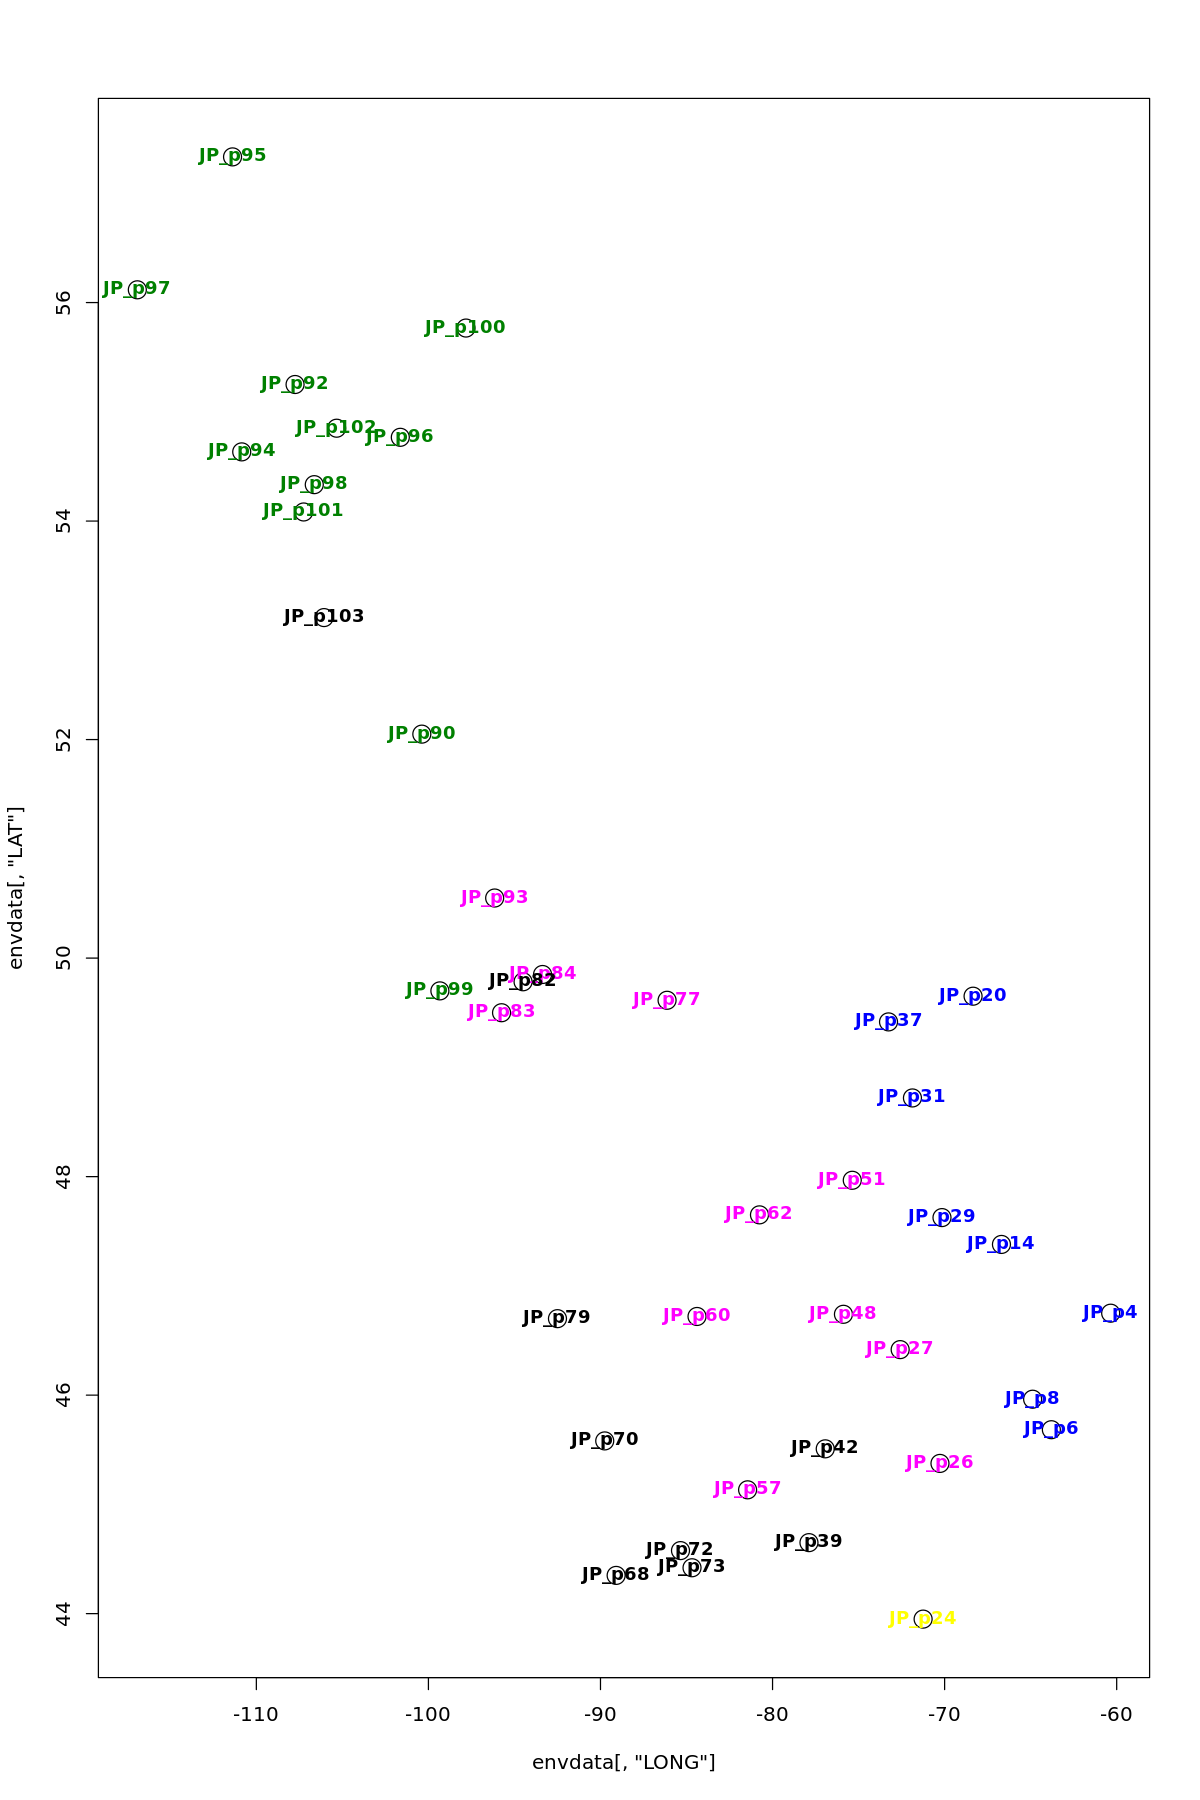

In [21]:
# prep envdata - map is west coast of North America
envdata <- prep_envdata(env_file, pops, plot=TRUE, colors=colors)

In [22]:
# Confirm that genotypes and environmental data are in the same order
identical(rownames(snps_imp), rownames(envstd))

[1] TRUE

In [23]:
dim(envstd)

[1] 40 21

In [24]:
dim(envdata)

[1] 40 27

                  user                 system                elapsed 
766.891000000000076398  27.725999999999999091  71.848999999999932697 
rda(formula = snps ~ AHM + CMD + DD5 + DD_0 + EMT + EXT + Eref + 
    FFP + MAP + MAT + MCMT + MSP + MWMT + NFFD + PAS + SHM + 
    TD + bFFP + eFFP + group_color + ElevationCentstd, data = envdata)
$r.squared
[1] 0.67697867966113123295

$adj.r.squared
[1] 0.16014456711894120566



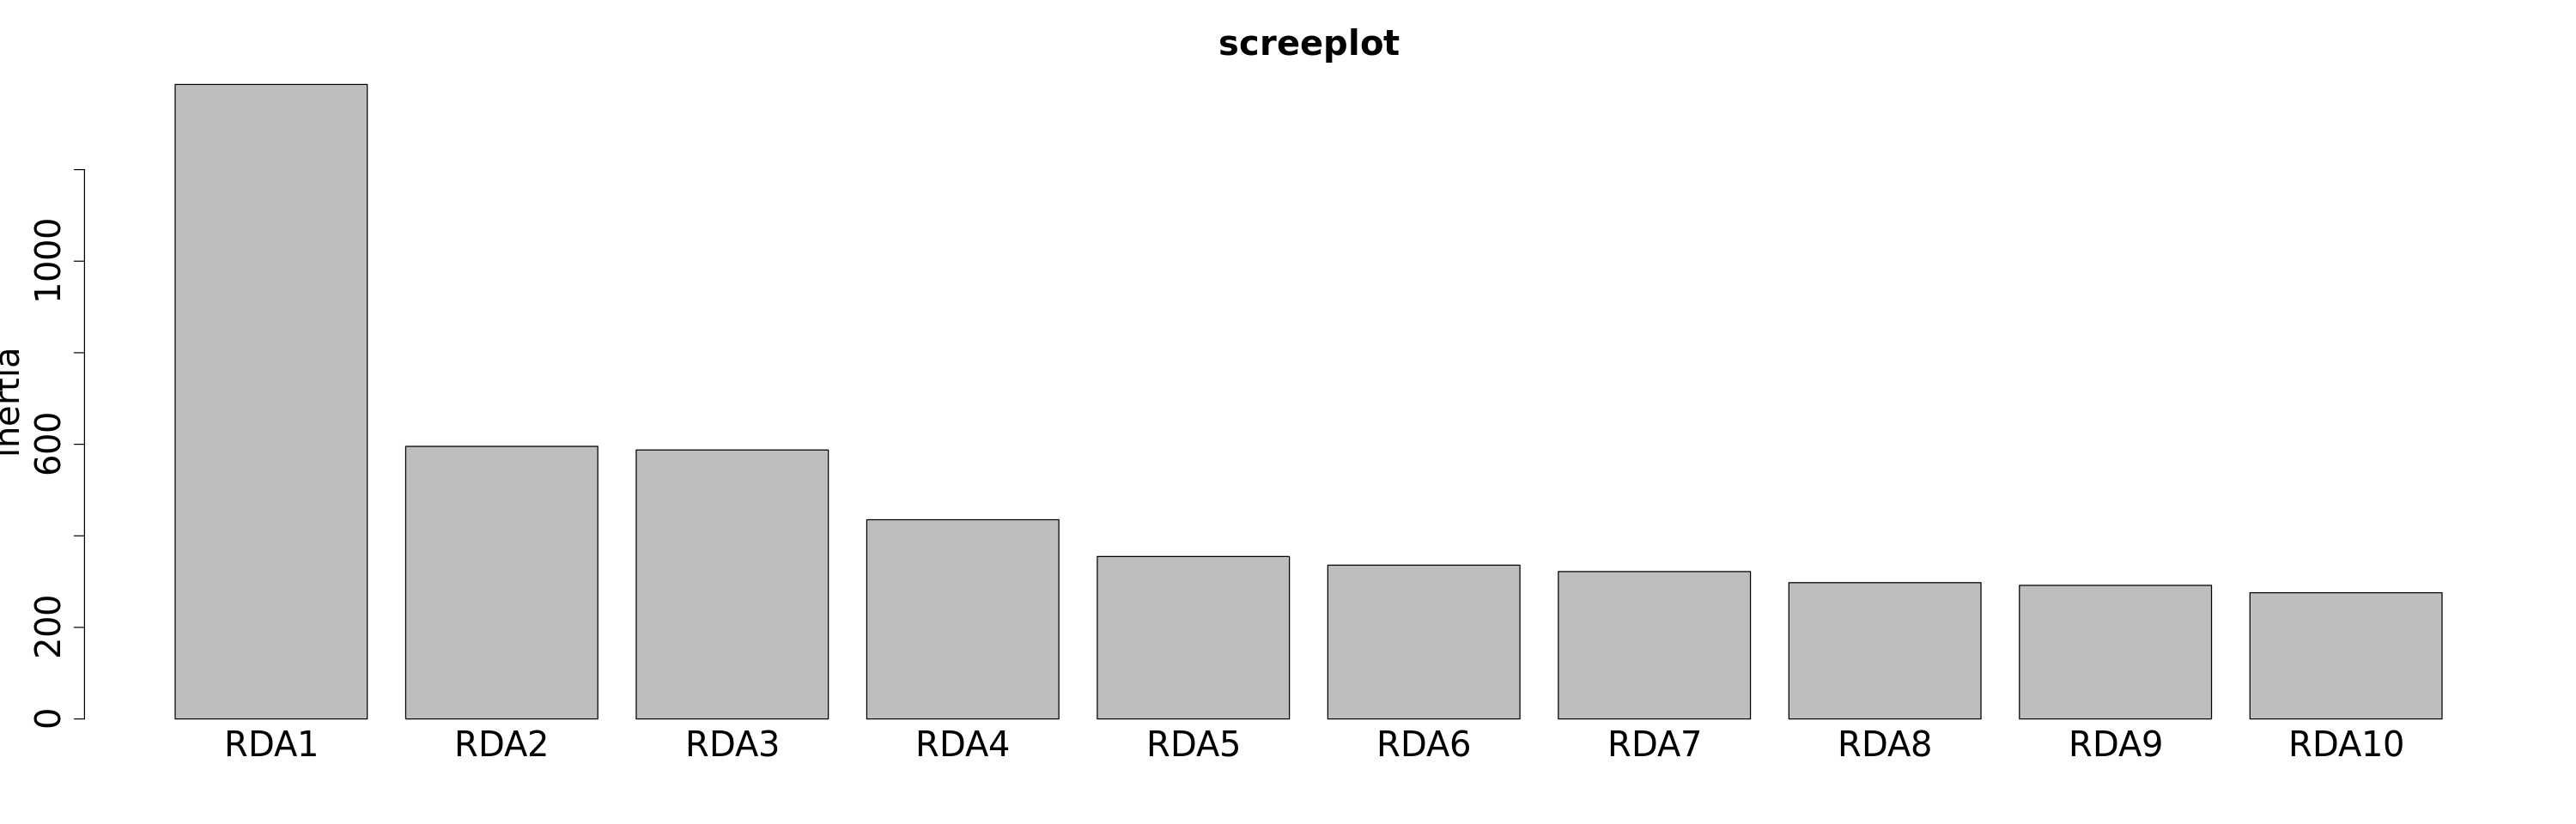

png 
  2

ERROR: Error in plot_rda(jp.rda, axes = c(1, 2), colors = colors): unused argument (colors = colors)


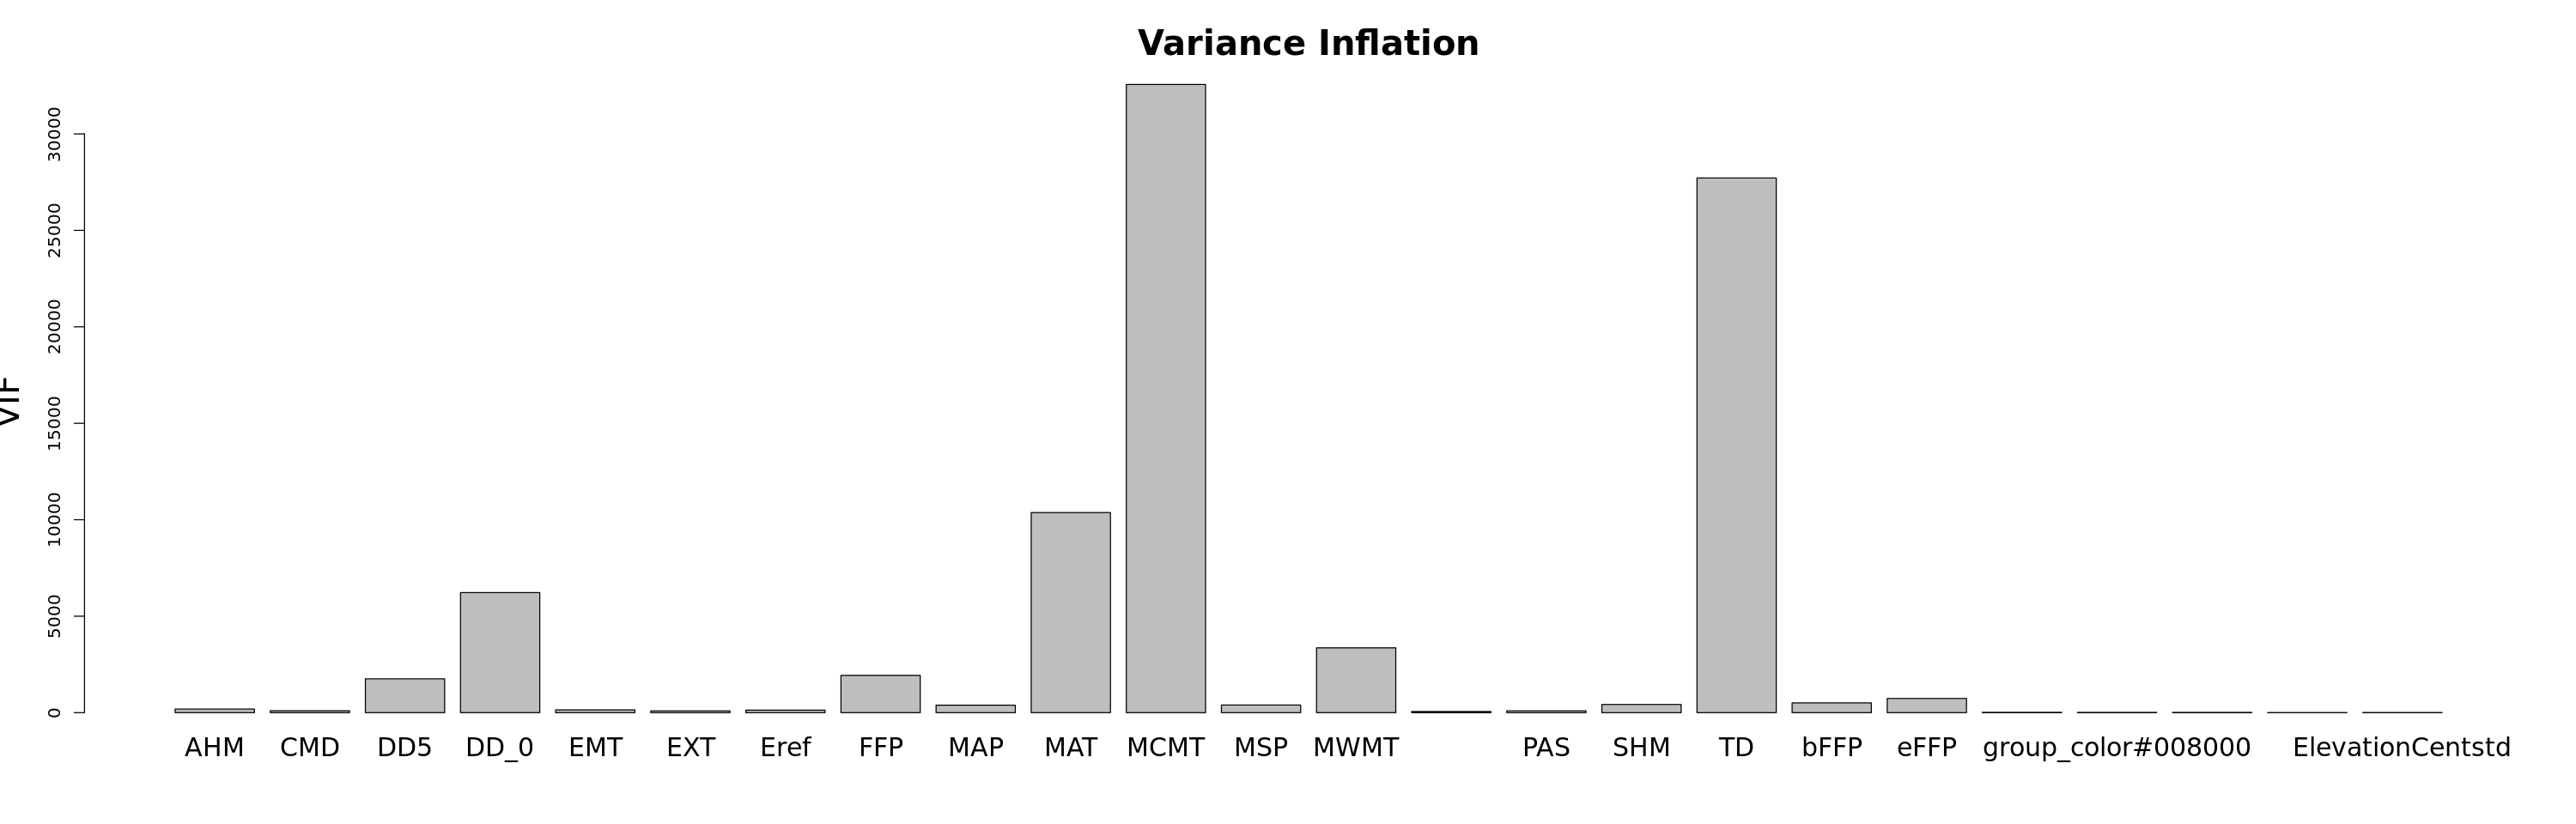

In [26]:
# do the RDA, plot

jp.rda <- prep_rda(snps_imp, envstd)

# plot axis 1 vs 2
# save a pdf
pdf(paste(rdadir, 'RDA_jp_all_vars_ax1-2.pdf', sep='/'))
plot_rda(jp.rda, axes=c(1,2))
dev.off()
# now so it shows up in notebook
plot_rda(jp.rda, axes=c(1,2), colors=colors)

# plot axis 1 vs 3
plot_rda(jp.rda, axes=c(1,3), colors=colors)

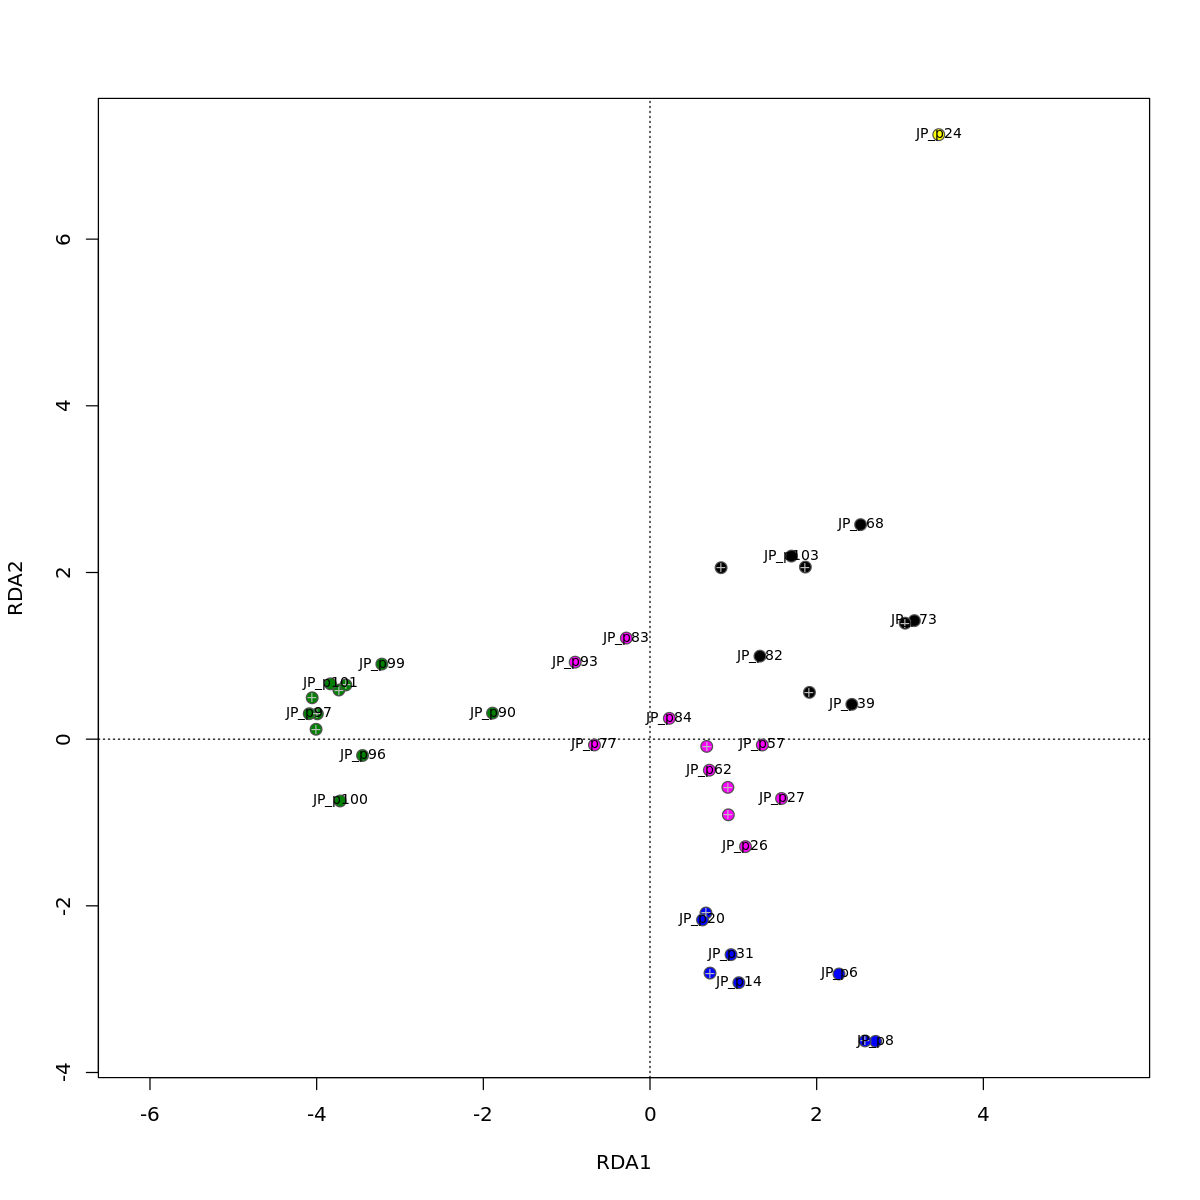

In [28]:
plot_rda(jp.rda, axes=c(1,2), .colors=colors, vectors=FALSE)

png 
  2

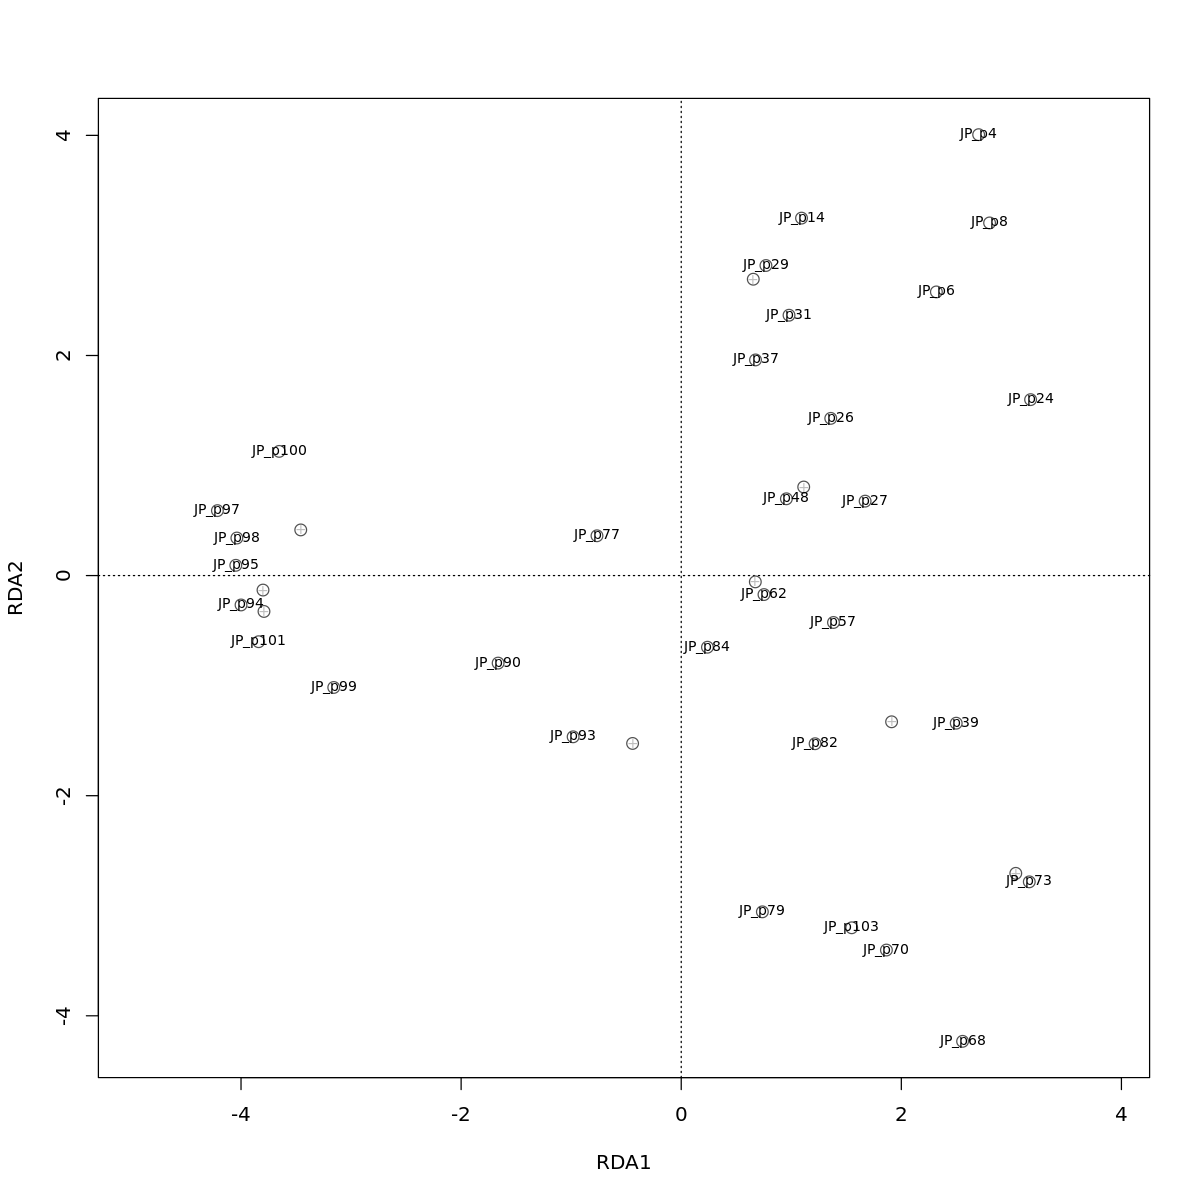

In [30]:
# save a fig showing PCA only (no env vectors)
pdf(paste0(rdadir, '/RDA_jp_all_vars_ax1-2_no-env-vectors.pdf'))
plot_rda(jp.rda, axes=c(1,2), vectors=FALSE, legendloc='bottom')
dev.off()
plot_rda(jp.rda, axes=c(1,2), vectors=FALSE, legendloc='bottom')

In [31]:
paste0(rdadir, '/RDA_jp_all_vars_ax1-2_no-env-vectors.pdf')

[1] "/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/rda/RDA_jp_all_vars_ax1-2_no-env-vectors.pdf"

#### compare imputed to no missing data

this shows the same basica overall patterns as imputed data

In [32]:
# load frequency data
nomissinglocidf = read.csv(no_missing_loci_file)
snps_noimp = subset(snps_imp, select = as.vector(nomissinglocidf[ ,'no_missing_loci']))
snps_noimp[1:5,1:20]

,>super4-15421,>super4-47333,>super4-47418,>super4-47461,>super4-47513,>super4-47541,>super4-47593,>super4-47619,>super4-47629,>super4-47661,>super4-47776,>super4-47803,>super4-47821,>super4-47839,>super4-47872,>super4-47977,>super4-47993,>super4-48065,>super4-48080,>super4-48094
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
JP_p98,0.72730000000000005755,0.081999999999999989564,0.200000000000000011102,0.000000000000000000000,0.55840000000000000746,0.00000000000000000000,0.012500000000000000694,0.92000000000000003997,0.95650000000000001688,0.000000000000000000000,0.139199999999999990408,0.064100000000000004197,0.060199999999999996569,0.102599999999999996758,0.027400000000000000744,0.85420000000000007034,0.045499999999999998779,0.82609999999999994547,0.086999999999999994005,0.65220000000000000195
JP_p31,0.84379999999999999449,0.090899999999999994693,0.185700000000000003952,0.000000000000000000000,0.56389999999999995683,0.00000000000000000000,0.000000000000000000000,0.95160000000000000142,0.95160000000000000142,0.000000000000000000000,0.108100000000000001643,0.099000000000000004663,0.094299999999999994937,0.104800000000000004263,0.000000000000000000000,0.98309999999999997389,0.000000000000000000000,1.00000000000000000000,0.074999999999999997224,0.82860000000000000320
JP_p93,0.76919999999999999485,0.211799999999999988276,0.257699999999999984635,0.048499999999999994504,0.39179999999999998161,0.00000000000000000000,0.044900000000000002409,0.90799999999999991829,0.90700000000000002842,0.011599999999999999201,0.107499999999999998335,0.042099999999999998535,0.044900000000000002409,0.069800000000000000933,0.038999999999999999944,0.97060000000000001830,0.000000000000000000000,1.00000000000000000000,0.302999999999999991562,0.50000000000000000000
JP_p24,0.85709999999999997300,0.000000000000000000000,0.070999999999999993672,0.409900000000000042100,0.11900000000000000855,0.00000000000000000000,0.433299999999999962963,0.51029999999999997584,0.51009999999999999787,0.000000000000000000000,0.047599999999999996481,0.050999999999999996725,0.030499999999999999334,0.037999999999999999056,0.000000000000000000000,0.85880000000000000782,0.000000000000000000000,0.79030000000000000249,0.000000000000000000000,0.29630000000000000782
JP_p14,0.57140000000000001901,0.082699999999999995737,0.211700000000000027045,0.074999999999999997224,0.50000000000000000000,0.11000000000000000056,0.145800000000000012923,0.84260000000000001563,0.86239999999999994440,0.076299999999999992828,0.070199999999999998512,0.048099999999999996925,0.045899999999999996358,0.072700000000000000733,0.044600000000000000755,0.83540000000000003144,0.079500000000000001221,0.80949999999999999734,0.079399999999999998357,0.65450000000000008171


In [33]:
# how many pops
nrow(snps_noimp)

[1] 40

In [34]:
# same order as before?
all(rownames(snps_noimp) == rownames(snps_imp))

[1] TRUE

In [35]:
# Confirm that genotypes and environmental data are in the same order
identical(rownames(snps_noimp), rownames(envstd))

[1] TRUE

                  user                 system                elapsed 
799.900000000000090949  26.230000000000003979  57.234000000000037289 
rda(formula = snps ~ AHM + CMD + DD5 + DD_0 + EMT + EXT + Eref + 
    FFP + MAP + MAT + MCMT + MSP + MWMT + NFFD + PAS + SHM + 
    TD + bFFP + eFFP + ElevationCentstd, data = envdata)
$r.squared
[1] 0.57862445396680317611

$adj.r.squared
[1] 0.13507124761606970065



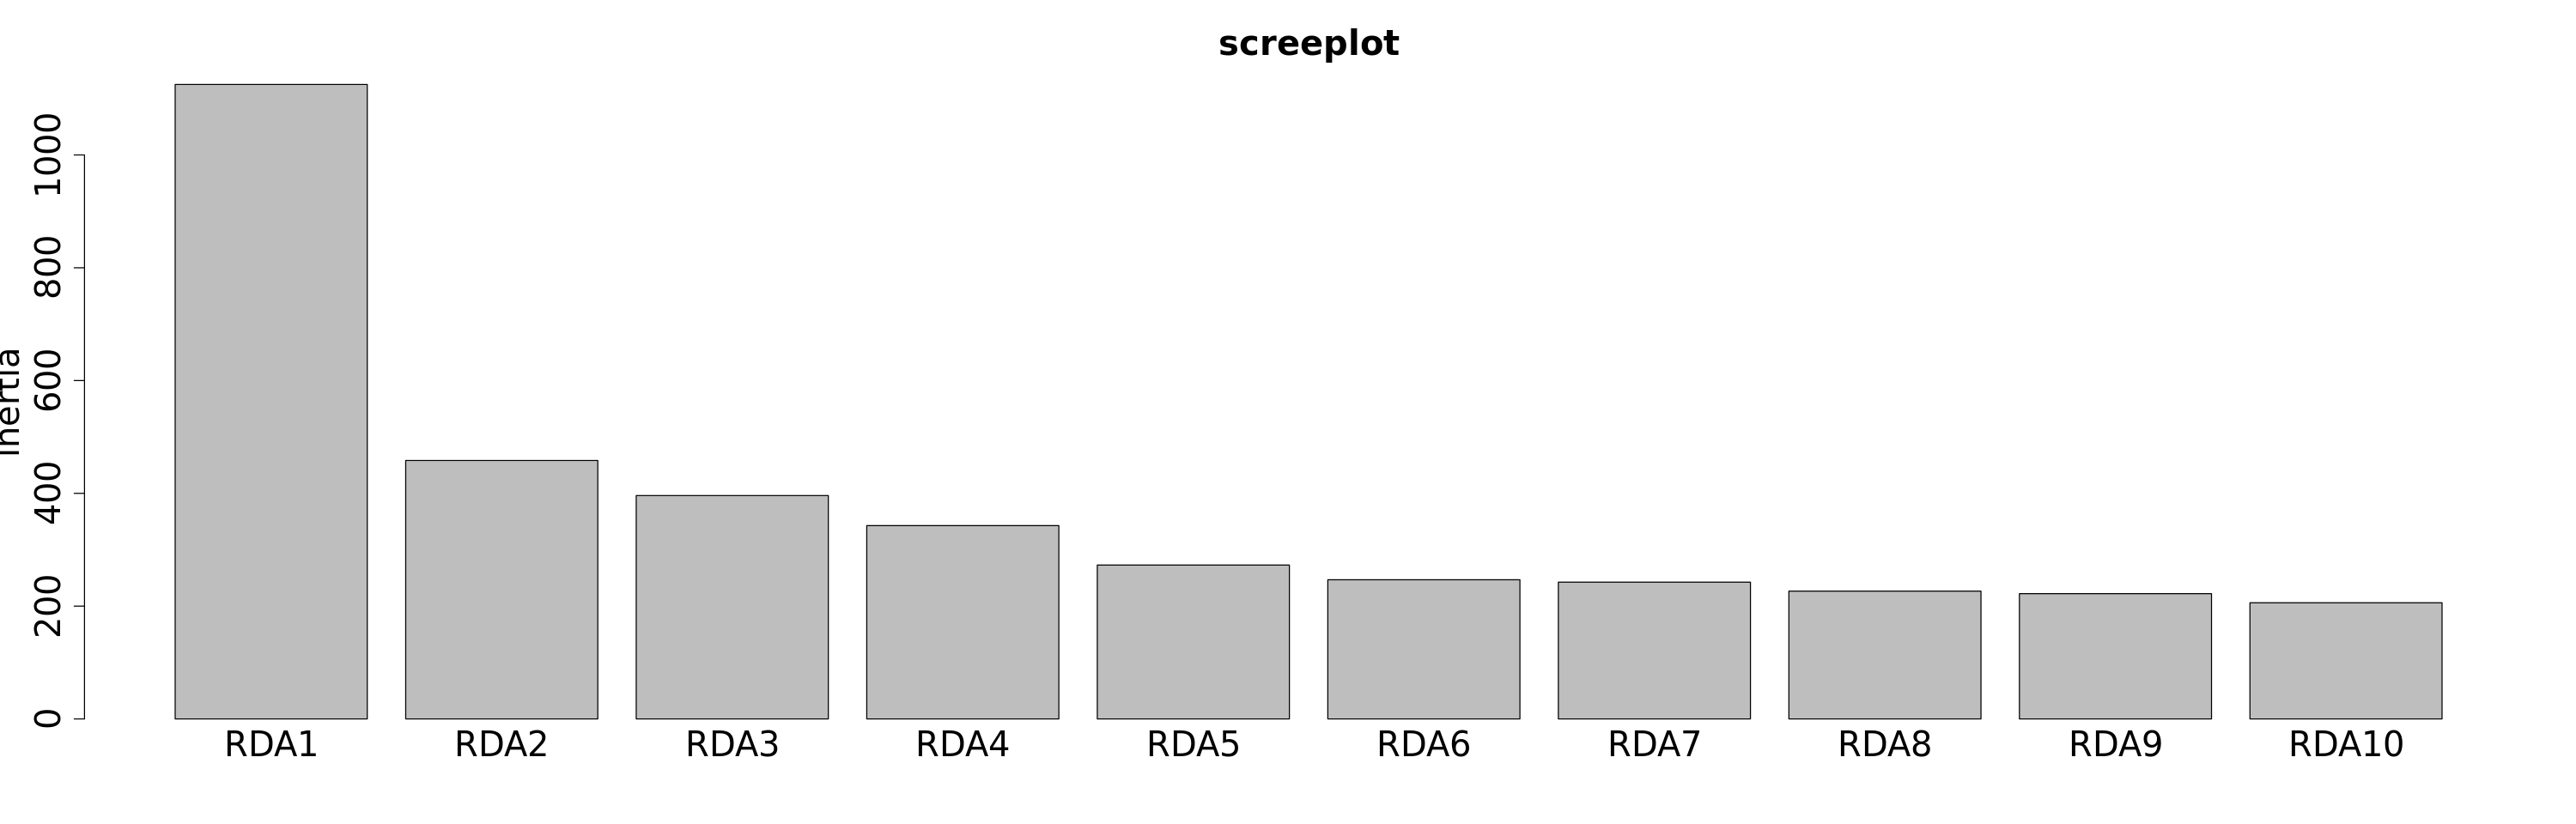

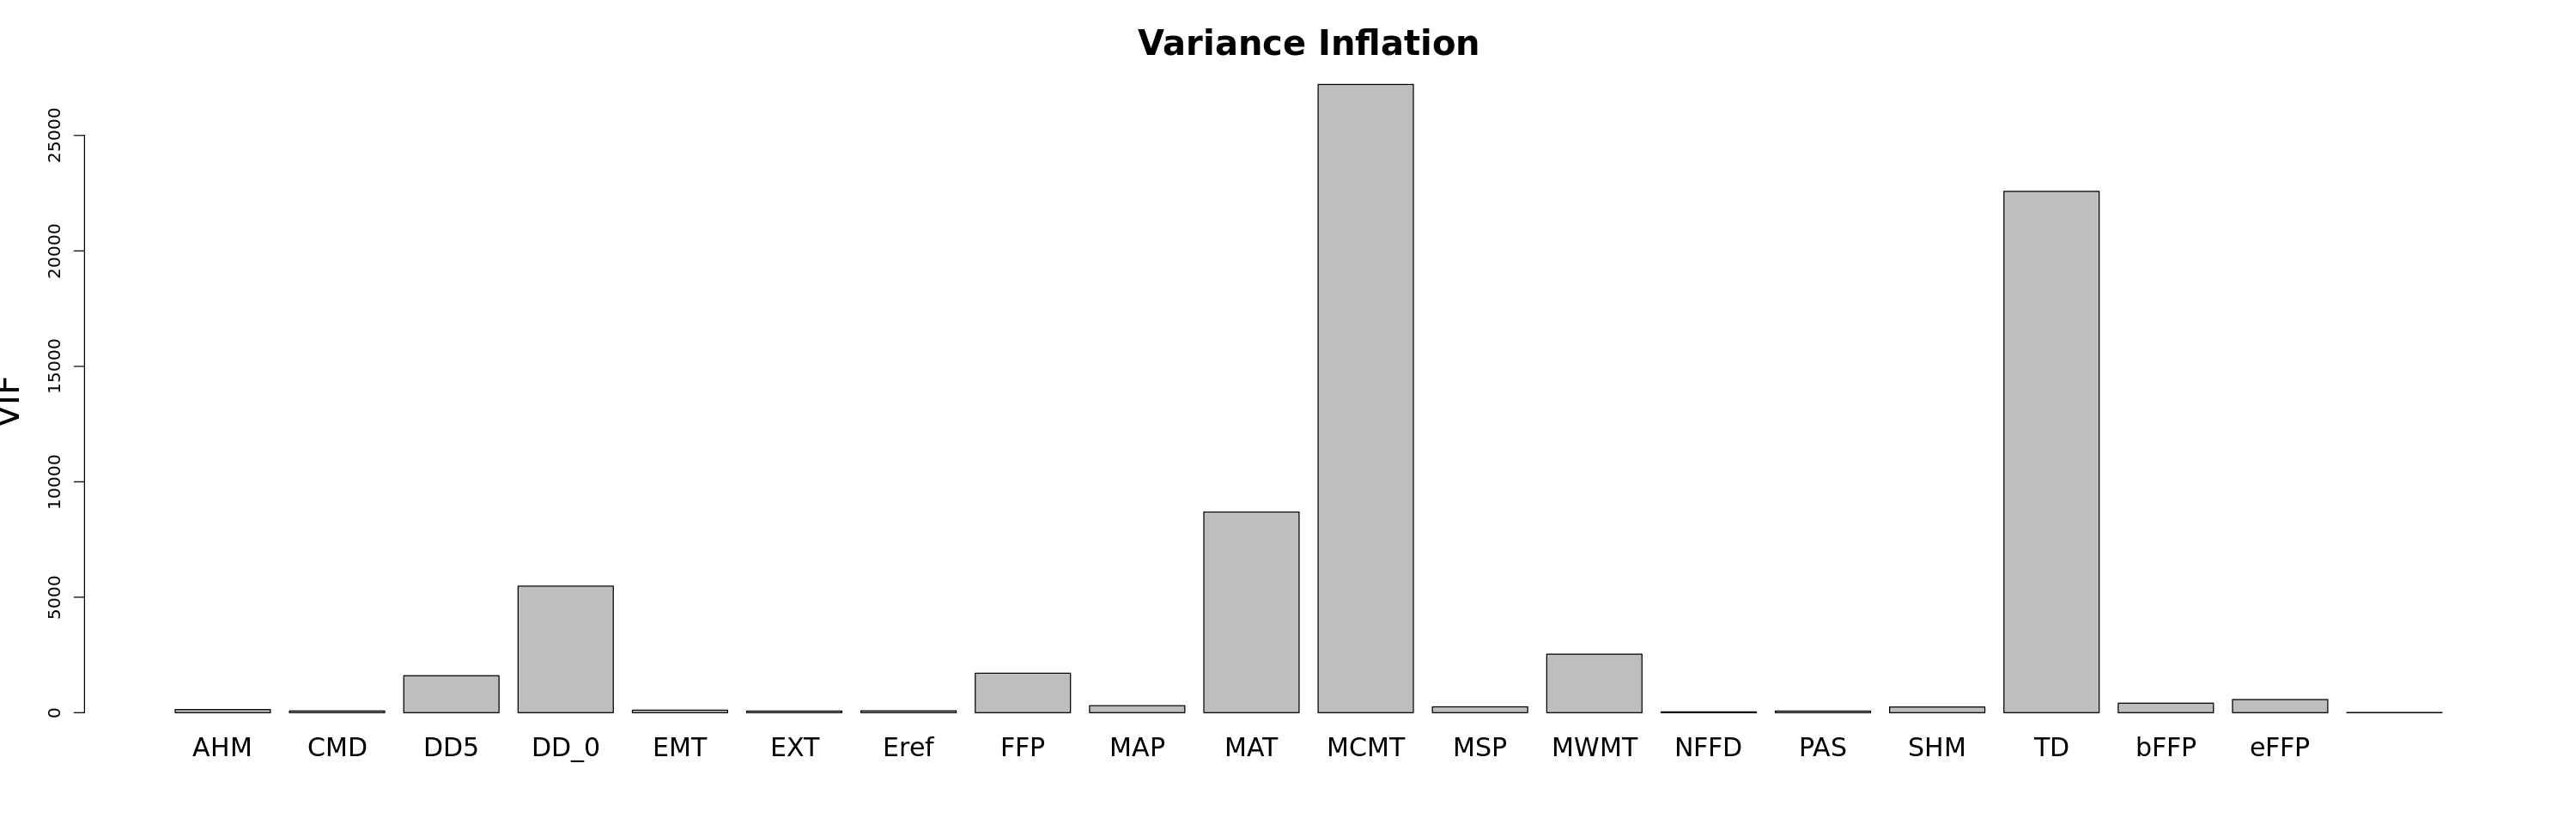

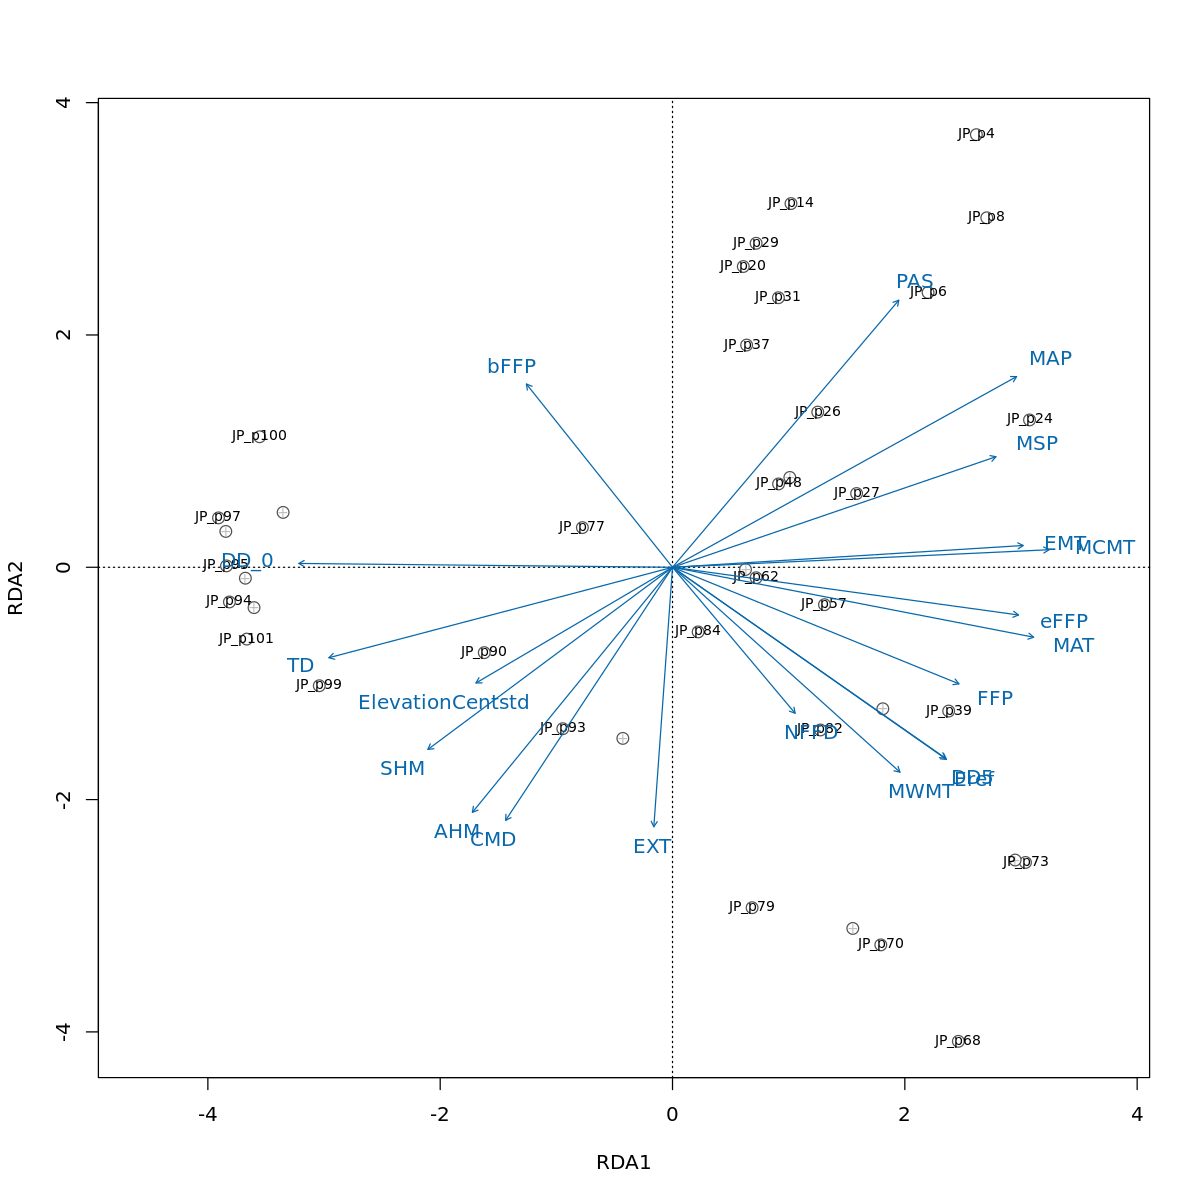

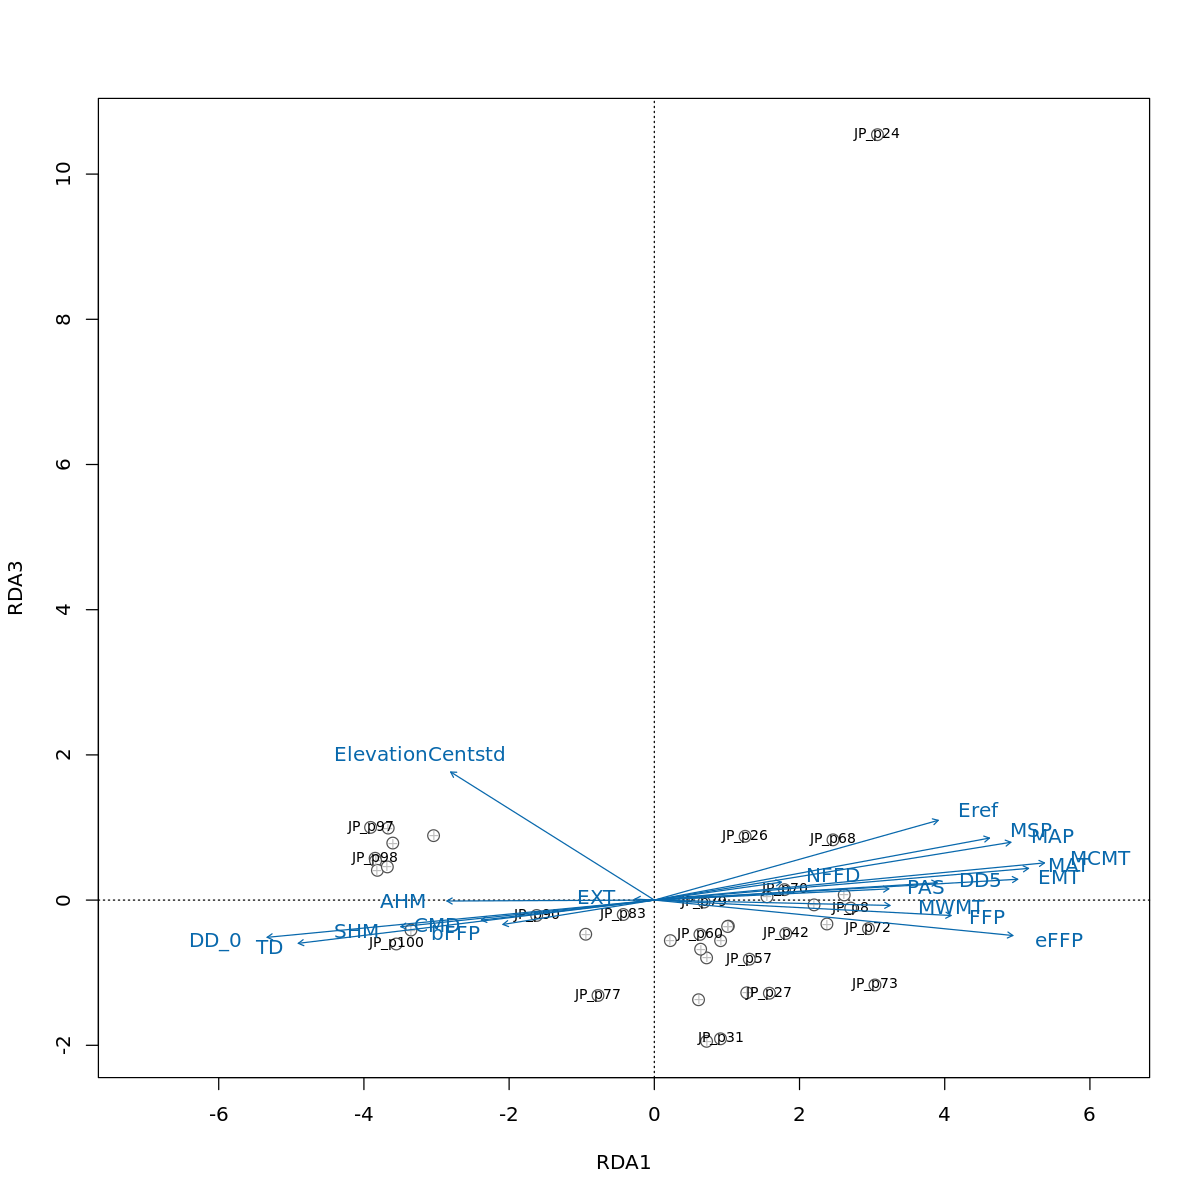

In [36]:
# do the RDA, plot
jp_noimp.rda <- prep_rda(snps_noimp, envstd)

# plot axis 1 vs 2
plot_rda(jp_noimp.rda, axes=c(1,2))

# plot axis 1 vs 3
plot_rda(jp_noimp.rda, axes=c(1,3))

# move forward with imputed SNPs

- exclude environmental variables to reduce variance inflation

#### get pairwise correlation among envs, build function so I can choose next env to eliminate

In [37]:
main_envs = colnames(envdata)[7:26]  # main 19 climatic variables + cent/std Elevation
len(main_envs)

[1] 20

In [38]:
# build environmental correlation matrix to explore variables after widdling due to variance inflation factor below
cormat = matrix(NA, ncol=len(main_envs), nrow=len(main_envs))
colnames(cormat) = main_envs
rownames(cormat) = main_envs
i = 0
for (envi in main_envs){
    j = 0
    for (envj in main_envs){
        if (i > j){
            cormat[envi,envj] = cor(envdata[,envi], envdata[,envj])
        }
        j = j + 1
    }
    i = i + 1
}
cormat

,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,ElevationCentstd
AHM,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CMD,0.927211568965770283057,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
DD5,0.254088677189443168380,0.292738548729561509631,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
DD_0,0.244320735125681920419,0.173505214590051859425,-0.73466457239903837362,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
EMT,-0.256371841000777200836,-0.176656576211008498056,0.68131017022972140129,-0.96862151931051465592,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
EXT,0.593062937689822211595,0.602956284311376600193,0.62090825314001973911,0.01790568585062316323,-0.082234655371698398008,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Eref,0.170367808403518228300,0.290720822095106634642,0.89336187085889429138,-0.72670438375613866100,0.617935306173515108696,0.560231004514749941769,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
FFP,0.166627979595625946851,0.131668244699347569693,0.91532178881138126503,-0.77028258721856768254,0.760040943178095007582,0.382934663278625186944,0.687807127945889384968,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,-0.833837774932872921596,-0.775037300869541811998,0.18700737796724162254,-0.70036224293650606310,0.686302633571051146077,-0.449915605830249643038,0.247974458010843223921,0.280958424108972204536,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAT,-0.084337468289417183431,-0.018378159400101221066,0.87518015975035945431,-0.97086638940077563120,0.930789191994858655654,0.205779916541198704127,0.831463687139467166887,0.870905328821216295765,0.563037315496443313556,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [39]:
avg_cors <- function(env_names){
    #------------------------------------------#
    # sort each env in env_names by descending #
    # average correlation with all other envs. #
    #------------------------------------------#
    .cormat = cormat[env_names, env_names]  # only the envs that matter
    z = data.frame('avg' = rep(0, len(env_names)))  # blank df to fill in
    rownames(z) = env_names
    for (env_name in env_names){
        x = cormat[env_name,][which(is.na(.cormat[env_name, ])==FALSE)]
        y = cormat[,env_name][which(is.na(.cormat[,env_name])==FALSE)]
        z[env_name, 'avg'] = abs(.mean(c(as.vector(x), as.vector(y))))
    }
    return(z[rev(rownames(z)[order(z$avg)]), ,drop=F])
}
z = avg_cors(main_envs)
z

,avg
,<dbl>
bFFP,0.3480553236166851749367
DD_0,0.3188468173052658172217
DD5,0.2980496692684456161437
MWMT,0.2803064248820680282037
Eref,0.2713395555801680902874
FFP,0.2660121752261840888387
MAT,0.2601193485328501253662
eFFP,0.2330749570390167335621
NFFD,0.2275196278328815158165


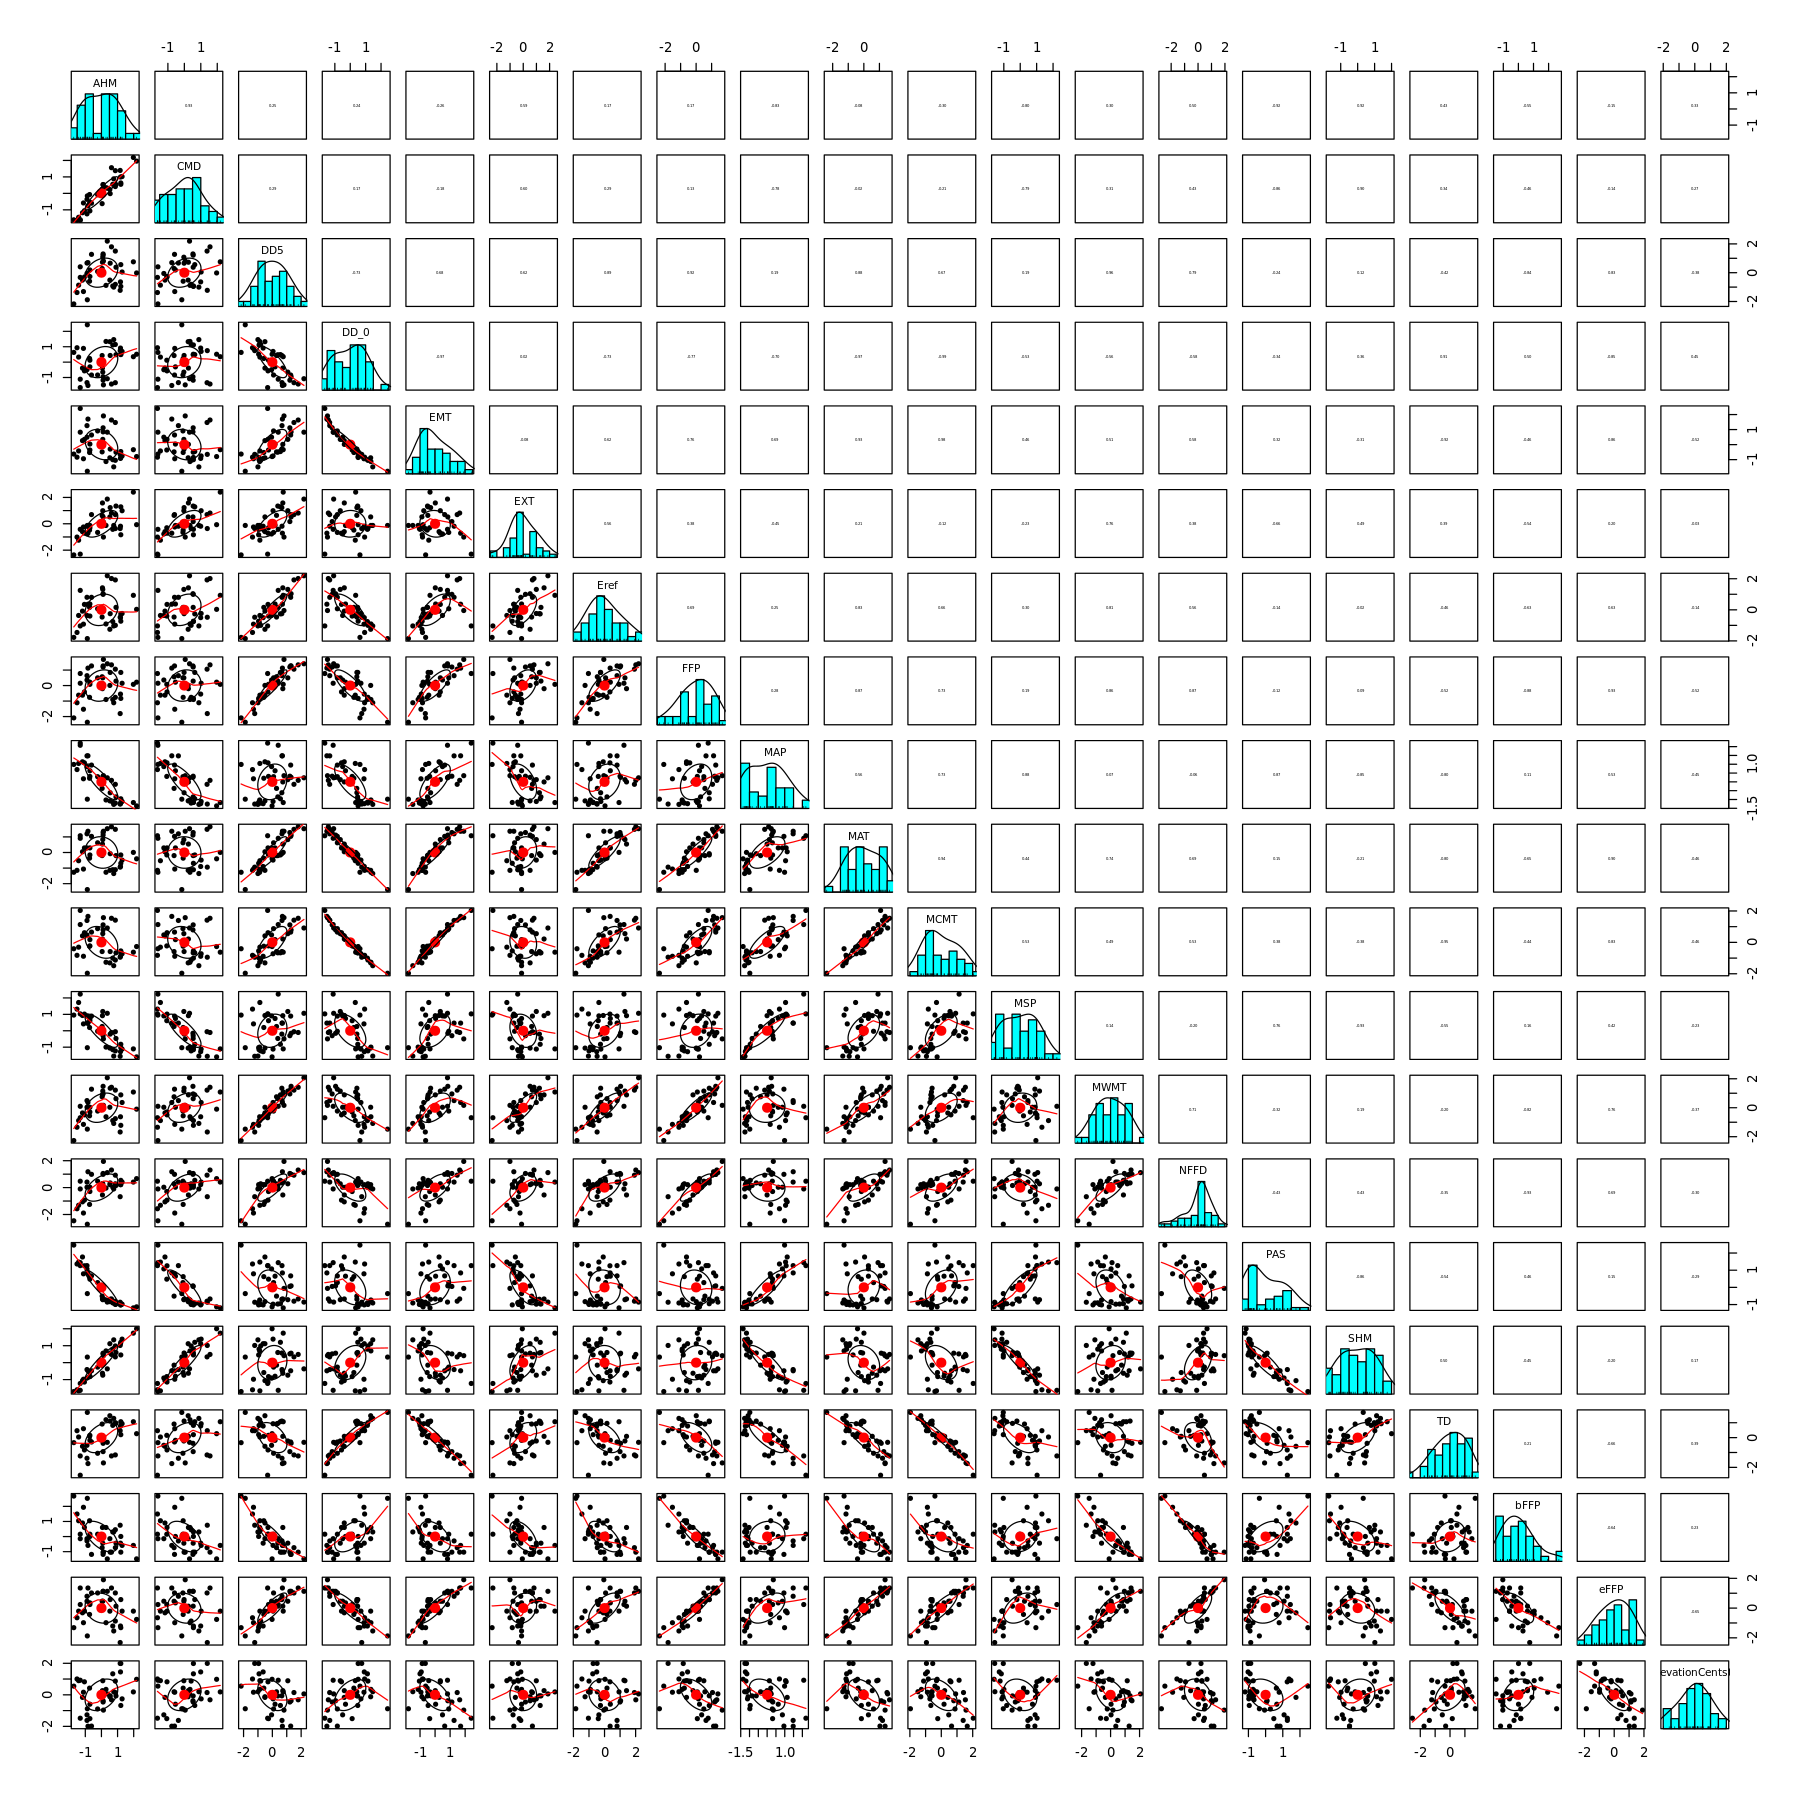

In [40]:
options(repr.plot.width=15, repr.plot.height=15)
pairs.panels(envdata[,main_envs], scale=F)

#### narrow down coastal envs

In [48]:
colnames(envstd)

[1] "AHM"              "CMD"              "DD_0"             "EMT"             
 [5] "EXT"              "Eref"             "MSP"              "MWMT"            
 [9] "NFFD"             "PAS"              "SHM"              "TD"              
[13] "bFFP"             "eFFP"             "ElevationCentstd"

In [52]:
# pick env variables to reduce inflation factors

exclude <- c('MCMT', 'MAT', 'FFP', 'MAP', 'DD5')

envdata <- prep_envdata(env_file, pops, plot=FALSE, exclude=exclude)

jp_rda <- prep_rda(snps_imp, envstd)

ERROR: Error in parse(text = x, srcfile = src): <text>:3:7: unexpected ')'
2: 
3: exclud)
         ^


In [57]:
plot_rda(jp_rda)

ERROR: Error in b[, choices <= rnk] <- x$CCA$biplot[, choices[choices <= rnk]]: NAs are not allowed in subscripted assignments


In [22]:
max(vif.cca(coastal_rda))

[1] 14.8094381575426155

In [23]:
vif.cca(coastal_rda)

TD                    MAP                    MSP 
 7.3355979035772147512 14.8094381575426154996 10.8108623152642913112 
                   AHM                    SHM                   DD_0 
 8.8602449550625159702  8.6614873016857991672 10.8612154530926687812 
                   FFP                    PAS       ElevationCentstd 
 8.4047821620076330618  8.4128876913377084179  8.1390956157313620878

In [24]:
avg_cors(names(vif.cca(coastal_rda)))

,avg
,<dbl>
MSP,0.502053723331999490753
DD_0,0.371662022611874254263
SHM,0.323351750037508212099
AHM,0.310400963757137660082
FFP,0.301496148529582286280
PAS,0.261791207334415465535
MAP,0.185504360473819546185
TD,0.125967076464722022022
ElevationCentstd,0.020826312293374001777


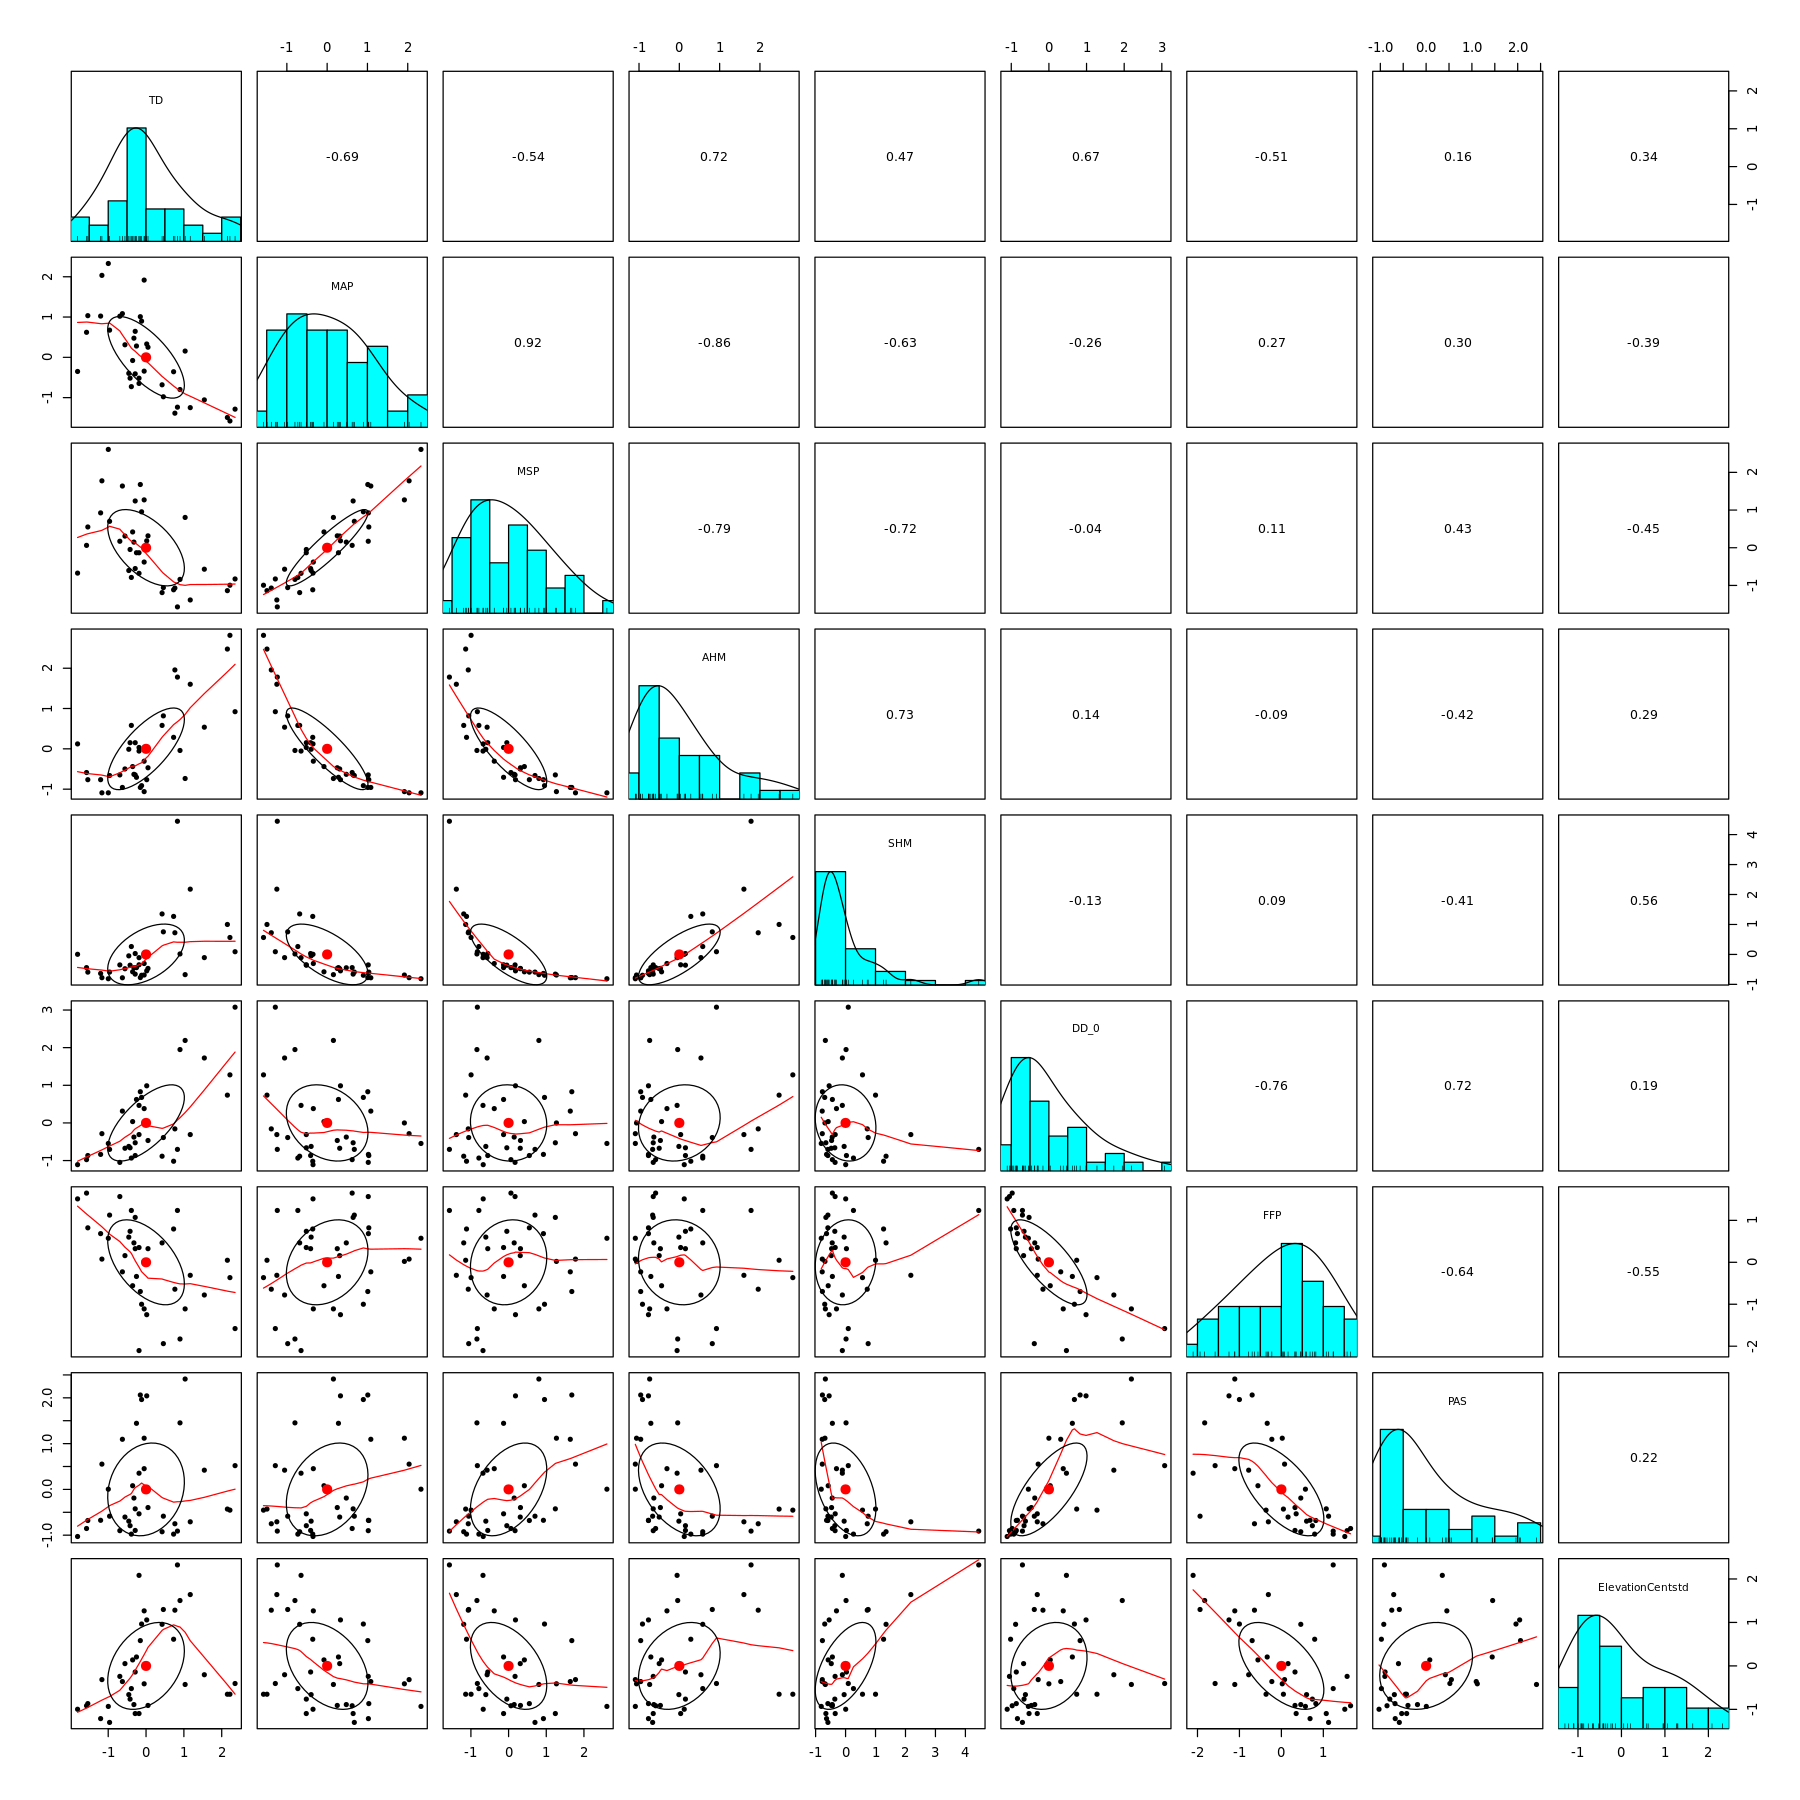

In [25]:
options(repr.plot.width=15, repr.plot.height=15)
pairs.panels(envdata[,names(vif.cca(coastal_rda))], scale=F)

In [26]:
rdadir

[1] "/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/rda"

In [27]:
# save RDA file
saveRDS(coastal_rda, rda_file)

In [28]:
# save excluded envs
saveRDS(exclude, exclude_file)

# calculate significance

In [ ]:
# restart notebook to clear mem

#### overall significance

In [3]:
print('loading rda ...')
coastal_rda <- readRDS(paste(rdadir, 'coastal_rda_imputed.RDS', sep='/'))

[1] "loading rda ..."


In [5]:
print('parallelizing permutations ...')
signif.full <- anova.cca(coastal_rda, parallel=35) # default is permutation=999

print('writing to file ...')
saveRDS(signif.full, signif_file)

[1] "loading rda ..."
[1] "parallelizing permutations ..."


Warning message in mclapply(1:nperm, function(i) getF(permutations[i, ]), mc.cores = parallel):
“scheduled core 6 did not deliver a result, all values of the job will be affected”


[1] "writing to file ..."


In [6]:
signif.full

,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,9,6845.033,1.537874,0.001
Residual,28,13847.462,NA,NA


In [7]:
summary(signif.full)

       Df           Variance           F             Pr(>F)     
 Min.   : 9.00   Min.   : 6845   Min.   :1.538   Min.   :0.001  
 1st Qu.:13.75   1st Qu.: 8596   1st Qu.:1.538   1st Qu.:0.001  
 Median :18.50   Median :10346   Median :1.538   Median :0.001  
 Mean   :18.50   Mean   :10346   Mean   :1.538   Mean   :0.001  
 3rd Qu.:23.25   3rd Qu.:12097   3rd Qu.:1.538   3rd Qu.:0.001  
 Max.   :28.00   Max.   :13847   Max.   :1.538   Max.   :0.001  
                                 NA's   :1       NA's   :1      

In [8]:
print(signif.full)

Permutation test for rda under reduced model
Permutation: free
Number of permutations: 999

Model: rda(formula = snps ~ TD + MAP + MSP + AHM + SHM + DD_0 + FFP + PAS + ElevationCentstd, data = envdata)
         Df Variance      F Pr(>F)    
Model     9     6845 1.5379  0.001 ***
Residual 28    13848                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


#### significant axes

```R
# execute in tmux
library(vegan)
rdadir = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/rda'

coastal_rda <- readRDS(paste(rdadir, 'coastal_rda_imputed.RDS', sep='/'))

signif.axis <- anova.cca(coastal_rda, by='axis', parallel=20, nperm=how(nperm=99)

signif_axis_file = paste(rdadir, 'coastal_rda_imputed-signif_axis_nperm99.RDS', sep='/')
saveRDS(signif.axis, signif_axis_file)
signif.axis
```

# Identify candidate SNPs involved in local adaptation

In [ ]:
# restart notebook

In [3]:
.get_corr <-function(locus){
    #----------------------------------------------------#
    # GET CORRELATION BETWEEN LOCUS AND ALL ENVIRONMENTS #
    #
    # Returns
    # -------
    # locus name with correlation for each environment
    # ... (tab separated)
    #----------------------------------------------------#
    freq <- snps[,locus]
    line <- paste(locus, paste(as.character(as.vector(apply(.envstd,2,function(x) cor(x,freq)))),collapse='\t'),
                  sep='\t')
    return(line)
}


.timelog <- function(){
    #----------------------------#
    # GET MILLISECOND TIME STAMP #
    #
    # Returns
    # -------
    # eg 08:01:01.001
    #----------------------------#
    options(digits.secs = 3)
    return (strsplit(as.character(Sys.time()), ' ')[[1]][2])
}

                                                      
get_candidates <- function(.rda, outpath, snps, .envstd=envstd, axes=c(1,2), z=2.5, engines=20){
    #------------------------------------------------------------------------#
    # GET CANDIDATE LOCI FROM RDA BASED ON Z-SCORE.
    #
    # Parameters
    # ----------
    # .rda - rda object output by vegan::rda()
    # outpath - where to save the candidate correlations
    # snps - FREQUENCYxPOP table from prep_snps()
    # .envstd - scaled environmental variables
    # axes - the list of significant axes from which to grab candidates
    # z - the z-score threshold by which to identify candidates for each axis
    # engines - the number of library(snow) engines to launch
    #------------------------------------------------------------------------#

    # Species (SNP) scores for the first 2 constrained axes
    load.rda <- scores(.rda, choices=axes, display="species")
    
    # plot hists
    #hist(load.rda[,1], main="Loadings on RDA1")
    #hist(load.rda[,2], main="Loadings on RDA2")
    
    # center/scale loadings so I can choose outliers manually later
    scaled.loadings <- scale(load.rda)
    for (i in 1:ncol(scaled.loadings)){
        colnames(scaled.loadings)[i] <- sprintf('RDA%s_zscore', i)
    }
    # colnames(scaled.loadings) <- c('RDA1_zscore', 'RDA2_zscore')
    
    # combine axis-loading scores and their z-scores
    load.rda <- cbind(load.rda, scaled.loadings)
    
    # combine candidate SNP names
    cands = list()
    ncand = 0
    for (axis in axes){
        message(sprintf('%s : Getting candidates from axis %s ...', .timelog(), axis))
        # set label names to grab data from load.rda table
        rda_label = sprintf('RDA%s', axis)
        z_label = sprintf('%s_zscore', rda_label)
        # grab axis candidates (based on z-score) along with their RDA axis score
        # axis_cands = load.rda[,rda_label] [abs(load.rda[,z_label]) >= z]
        axis_cands = data.frame(load.rda[abs(load.rda[,z_label]) >= z ,c(rda_label, z_label)])
        axis_cands[,'axis'] <- axis
        colnames(axis_cands) <- c('RDA_score', 'RDA_zscore', 'axis')
        # add axis candidates to full candidate list
        cands[[len(cands)+1]] <- axis_cands
        # count total candidates
        # ncand = ncand + len(axis_cands)
        ncand = ncand + nrow(axis_cands)
    }
    message(sprintf('%s : Found %s candidate loci ...', .timelog(), ncand))
    
    # create a dataframe for candidates on each axis
    dfs = list()
    for (axis in axes){
        message(sprintf('%s : Creating candidate dataframe for axis %s ...', .timelog(), axis))
        df <- cands[[axis]]
        df[,'snp'] <- rownames(df)
        dfs[[len(dfs)+1]] <- df
    }
    
    # combine all of the axis candidate dataframes
    cand <- dplyr::bind_rows(dfs)
    cand$snp <- as.character(cand$snp)
    
    # add in the correlations of each candidate SNP with the environmental predictors
    message(sprintf('%s : Starting up cluster with %s engines ...', .timelog(), as.character(engines)))
    cl = makeSOCKcluster(engines)
    # export data to cluster
    message(sprintf('%s : Sending snps and envstd objects to engines ...', .timelog()))
    exports = c('snps', '.envstd')
    clusterExport(cl, exports, envir=environment())
    # get correlation for each locus for each env in parallel
    message(sprintf('%s : Running correlations in parallel ...', .timelog()))
    loci <- as.array(cand[,'snp'])
    out <- parApply(cl, loci, 1, .get_corr)
    # collapse all lines by new line ending
    message(sprintf('%s : Gathering results from engines ...', .timelog()))
    lines <- paste(out, collapse='\n')
    # write colnames and rows, stop cluster
    message(sprintf('%s : Writing results to outfile: %s', .timelog(), outpath))
    columns <- paste(paste('locus', paste(colnames(envstd), collapse='\t'),sep='\t'), '\n', sep='')
    write(columns, file=outpath)
    write(lines, file=outpath)
    stopCluster(cl)

    # read in the correlations, combine with candidate dataframe
    message(sprintf('%s : Reading in outfile ...', .timelog()))
    cors <- fread(outpath, header=F, sep='\t')
    colnames(cors) <- c('locus', colnames(.envstd))
    cand <- cbind.data.frame(cand, cors)

    return(cand)
}

#### imputed

In [4]:
# reload RDA
coastal_rda <- readRDS(rda_file)

In [5]:
# reload frequency data
snps_imp <- prep_snps(snp_file)
pops <- rownames(snps_imp)
len(pops)

[1] 38

In [6]:
# reload environmental data
exclude = readRDS(exclude_file)
envdata <- prep_envdata(env_file, pops, plot=FALSE, exclude=exclude)

There are 9 environmental attributes in the envdata table.

In [7]:
ptm <- proc.time()  # see how long it takes
coast.cand <- get_candidates(coastal_rda,
                             tmp_candidate_file,
                             snps_imp)
print(proc.time() - ptm)

02:37:31.761 : Getting candidates from axis 1 ...

02:37:31.851 : Getting candidates from axis 2 ...

02:37:31.935 : Found 115155 candidate loci ...

02:37:31.938 : Creating candidate dataframe for axis 1 ...

02:37:31.940 : Creating candidate dataframe for axis 2 ...

02:37:32.291 : Starting up cluster with 20 engines ...

02:37:42.511 : Sending snps and envstd objects to engines ...

02:40:16.991 : Running correlations in parallel ...

02:44:17.646 : Gathering results from engines ...

02:44:17.814 : Writing results to outfile: /data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/rda/interior_candidates.txt

02:44:17.898 : Reading in outfile ...



                  user                 system                elapsed 
 33.401999999999993918  22.099999999999997868 407.480999999999994543 


In [8]:
head(coast.cand)

,RDA_score,RDA_zscore,axis,snp,locus,TD,MAP,MSP,AHM,SHM,DD_0,FFP,PAS,ElevationCentstd
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
jcf7190000000004-54857,-0.018173434725295544573,-2.7583243099352046102,1,jcf7190000000004-54857,jcf7190000000004-54857,0.1363540110688220008406,0.181314476343822000848,0.30818019825404702194,-0.206699109935280012085,-0.30827017614973201143,0.46990740436664202306,-0.071261688006405393692,0.39476670542345398962,-0.38963526429319800259
jcf7190000000004-55975,-0.019312709323778071147,-2.9335546547297139952,1,jcf7190000000004-55975,jcf7190000000004-55975,0.0804849774531239958719,0.259606145348854011612,0.44827830020540399003,-0.274872762428621020270,-0.41019797093192000847,0.43883714516757599267,-0.075815860199717893808,0.45996871963621499546,-0.44212400842445498395
jcf7190000000004-56338,-0.017399713686076290209,-2.6393192828260745308,1,jcf7190000000004-56338,jcf7190000000004-56338,0.2152230180601990006117,0.147944564529933986208,0.31084471515766498584,-0.182498949416699002279,-0.27167153117859499378,0.53429037725814099158,-0.252203446510290973936,0.48540392460620201964,-0.15890668968300300512
jcf7190000000004-56472,0.016456437274643669760,2.5680512792526100085,1,jcf7190000000004-56472,jcf7190000000004-56472,0.0041220973068863296304,-0.314920658627844018973,-0.45383690998119302629,0.289377766077181020066,0.49681750331202501059,-0.35232121637906599343,0.127648758739207002222,-0.44493090818360997440,0.35506501054420902541
jcf7190000000004-57312,-0.017031333241756877600,-2.5826591656255106777,1,jcf7190000000004-57312,jcf7190000000004-57312,0.1451168936498359873788,0.197684566810146011839,0.30465162080170599124,-0.218355196621559999315,-0.36343490911672099442,0.42428469683961500536,-0.166506856405785996778,0.34149891323282999256,-0.34210028072312198555
jcf7190000000004-136878,-0.016714914289720536611,-2.5339911779966302063,1,jcf7190000000004-136878,jcf7190000000004-136878,0.3762893135957779966461,0.054708421025174300278,0.13841218059441801058,-0.068319591464257603541,-0.11645169238920100030,0.43348832166944800681,-0.099754836946340699755,0.29839682459059202468,-0.18743798245770801336


In [9]:
# make sure locus labels are correct to ensure they didn't get shuffled during parallelization
all(coast.cand[,'snp'] == coast.cand[,'locus'])

[1] TRUE

# investigate the candidates

In [10]:
# how many unique candidates
len(uni(coast.cand$snp))

[1] 110487

##### handle duplicates - keep the duplicate with the highest axis loading

in the example, they exclude markers that are duplicated across axes, I'm not going to do that.

In [11]:
# how many rows (includes duplicates)
nrow(coast.cand)

[1] 115155

In [12]:
# how many are duplicated
sum(duplicated(coast.cand$snp))

[1] 4668

In [13]:
foo <- cbind(coast.cand$axis, duplicated(coast.cand$snp)) 
table(foo[foo[,1]==1,2])


    0 
58336 

In [14]:
# all are duplicated on axis 2
table(foo[foo[,1]==2,2])


    0     1 
52151  4668 

In [15]:
# determine which rows to keep

t = table(coast.cand$snp) # count snps
dups = names(t[t >= 2])  # ID duplicates
# figure out which duplicate to keep - keep the one with highest loading
x = coast.cand[coast.cand$snp %in% dups,]
x = x[rownames(x)[order(x$snp)],]
if (len(dups) > 0){
    keep = c()
    for (snp in dups){
        snpdf = x[x$snp==snp,]
        maxx = 0
        whichrow = 0
        for (row in rownames(snpdf)){
            if (abs(snpdf[row, 'RDA_score']) > maxx){
                maxx = abs(snpdf[row, 'RDA_score'])
                whichrow = row
            }
        }
        keep = c(keep, whichrow)
    }  
    stopifnot(len(keep) == nrow(x)/2)
} else keep = coast.cand$snp
len(keep)

[1] 4668

In [16]:
# filter interior.cand to remove the lower scoring duplicates
if (len(dups) > 0){
    dupdf = coast.cand[keep, ]
    print(nrow(dupdf))
    cand <- coast.cand[!rownames(coast.cand) %in% rownames(x),]  # remove duplicate detections
    print(nrow(cand))
    cand <- rbind(cand, dupdf)  # combine    
} else cand <- coast.cand
rownames(cand) <- 1:range(nrow(cand))  # rename rows
nrow(cand)

[1] 4668
[1] 105819


Warning message in 1:range(nrow(cand)):
“numerical expression has 2 elements: only the first used”


[1] 110487

#### assign predictors to each outlier locus

In [17]:
rda_envs = colnames(cand)[colnames(cand) %in% colnames(envdata)]
rda_envs

[1] "TD"               "MAP"              "MSP"              "AHM"             
[5] "SHM"              "DD_0"             "FFP"              "PAS"             
[9] "ElevationCentstd"

In [18]:
head(cand)

,RDA_score,RDA_zscore,axis,snp,locus,TD,MAP,MSP,AHM,SHM,DD_0,FFP,PAS,ElevationCentstd
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.018173434725295544573,-2.7583243099352046102,1,jcf7190000000004-54857,jcf7190000000004-54857,0.1363540110688220008406,0.181314476343822000848,0.30818019825404702194,-0.206699109935280012085,-0.30827017614973201143,0.46990740436664202306,-0.071261688006405393692,0.39476670542345398962,-0.38963526429319800259
2,-0.019312709323778071147,-2.9335546547297139952,1,jcf7190000000004-55975,jcf7190000000004-55975,0.0804849774531239958719,0.259606145348854011612,0.44827830020540399003,-0.274872762428621020270,-0.41019797093192000847,0.43883714516757599267,-0.075815860199717893808,0.45996871963621499546,-0.44212400842445498395
3,-0.017399713686076290209,-2.6393192828260745308,1,jcf7190000000004-56338,jcf7190000000004-56338,0.2152230180601990006117,0.147944564529933986208,0.31084471515766498584,-0.182498949416699002279,-0.27167153117859499378,0.53429037725814099158,-0.252203446510290973936,0.48540392460620201964,-0.15890668968300300512
4,0.016456437274643669760,2.5680512792526100085,1,jcf7190000000004-56472,jcf7190000000004-56472,0.0041220973068863296304,-0.314920658627844018973,-0.45383690998119302629,0.289377766077181020066,0.49681750331202501059,-0.35232121637906599343,0.127648758739207002222,-0.44493090818360997440,0.35506501054420902541
5,-0.017031333241756877600,-2.5826591656255106777,1,jcf7190000000004-57312,jcf7190000000004-57312,0.1451168936498359873788,0.197684566810146011839,0.30465162080170599124,-0.218355196621559999315,-0.36343490911672099442,0.42428469683961500536,-0.166506856405785996778,0.34149891323282999256,-0.34210028072312198555
6,-0.016714914289720536611,-2.5339911779966302063,1,jcf7190000000004-136878,jcf7190000000004-136878,0.3762893135957779966461,0.054708421025174300278,0.13841218059441801058,-0.068319591464257603541,-0.11645169238920100030,0.43348832166944800681,-0.099754836946340699755,0.29839682459059202468,-0.18743798245770801336


In [19]:
# see which of the predictors each candidate SNP is most strongly correlated with
# this is reallllyyyyyyy slow .....
env_col = ncol(cand) + 1
cor_col = env_col + 1
for (i in 1:length(cand$snp)) {
    if (i %% 100 == 0){
        # echo so I don't get a lot of printouts
            # instead I can watch in the terminal window that's running notebook
        system(sprintf('echo %s', as.character(i)))
    }
    bar <- cand[i,]
    cand[i,env_col] <- names(which.max(abs(bar[rda_envs]))) # environmental variable
    cand[i,cor_col] <- max(abs(bar[rda_envs]))              # correlation
}

colnames(cand)[env_col] <- "predictor"
colnames(cand)[cor_col] <- "correlation"

table(cand$predictor) 


             AHM             DD_0 ElevationCentstd              FFP 
             941            15001            13826             8481 
             MAP              MSP              PAS              SHM 
            1136            26149            13081            16489 
              TD 
           15383 

In [20]:
head(cand)

,RDA_score,RDA_zscore,axis,snp,locus,TD,MAP,MSP,AHM,SHM,DD_0,FFP,PAS,ElevationCentstd,predictor,correlation
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-0.018173434725295544573,-2.7583243099352046102,1,jcf7190000000004-54857,jcf7190000000004-54857,0.1363540110688220008406,0.181314476343822000848,0.30818019825404702194,-0.206699109935280012085,-0.30827017614973201143,0.46990740436664202306,-0.071261688006405393692,0.39476670542345398962,-0.38963526429319800259,DD_0,0.46990740436664202306
2,-0.019312709323778071147,-2.9335546547297139952,1,jcf7190000000004-55975,jcf7190000000004-55975,0.0804849774531239958719,0.259606145348854011612,0.44827830020540399003,-0.274872762428621020270,-0.41019797093192000847,0.43883714516757599267,-0.075815860199717893808,0.45996871963621499546,-0.44212400842445498395,PAS,0.45996871963621499546
3,-0.017399713686076290209,-2.6393192828260745308,1,jcf7190000000004-56338,jcf7190000000004-56338,0.2152230180601990006117,0.147944564529933986208,0.31084471515766498584,-0.182498949416699002279,-0.27167153117859499378,0.53429037725814099158,-0.252203446510290973936,0.48540392460620201964,-0.15890668968300300512,DD_0,0.53429037725814099158
4,0.016456437274643669760,2.5680512792526100085,1,jcf7190000000004-56472,jcf7190000000004-56472,0.0041220973068863296304,-0.314920658627844018973,-0.45383690998119302629,0.289377766077181020066,0.49681750331202501059,-0.35232121637906599343,0.127648758739207002222,-0.44493090818360997440,0.35506501054420902541,SHM,0.49681750331202501059
5,-0.017031333241756877600,-2.5826591656255106777,1,jcf7190000000004-57312,jcf7190000000004-57312,0.1451168936498359873788,0.197684566810146011839,0.30465162080170599124,-0.218355196621559999315,-0.36343490911672099442,0.42428469683961500536,-0.166506856405785996778,0.34149891323282999256,-0.34210028072312198555,DD_0,0.42428469683961500536
6,-0.016714914289720536611,-2.5339911779966302063,1,jcf7190000000004-136878,jcf7190000000004-136878,0.3762893135957779966461,0.054708421025174300278,0.13841218059441801058,-0.068319591464257603541,-0.11645169238920100030,0.43348832166944800681,-0.099754836946340699755,0.29839682459059202468,-0.18743798245770801336,DD_0,0.43348832166944800681


In [21]:
nrow(cand)

[1] 110487

In [22]:
uni(cand$axis)

[1] 1 2

#### plot the snps

In [31]:
.create_fig <- function(.rda, xlim, ylim, revert_col.pred, empty.outline, empty, cols, bg){
    options(repr.plot.width=10, repr.plot.height=10)
    plot(.rda, type="n", scaling=3, xlim=xlim, ylim=ylim)
    points(.rda, display="species", pch=21, cex=1, col="gray32", bg=revert_col.pred, scaling=3)
    points(.rda, display="species", pch=21, cex=1, col=empty.outline, bg=empty, scaling=3)
    text(.rda, scaling=3, display="bp", col="#0868ac", cex=1)
    legend("topright", legend=cols, bty="n",
           col="gray32", pch=21, cex=1, pt.bg=bg)
}

plot_candidates <- function(.rda, z=NA, save=TRUE, xlim=c(-0.15,0.15), ylim=c(-0.15,0.15), figfile=NA, display=TRUE){
    #--------------------------------------------------#
    # +   COLOR CODE OUTLIERS BY BEST PREDICTOR
    # +/- REDUCE OUTLIERS BY AXIS LOADING Z-SCORE
    # +/- PLOT CANDIDATE OUTLIERS ON RDA AXES
    # +/- SAVE PLOTTED FIGURE AS PDF
    #
    # Notes
    # -----
    # - the following are placed into global namespace
    # reorder_col.pred, revert_col.pred, empty.outline,
    # empty
    # 
    #--------------------------------------------------#
    
    # 1) reduce candidate data.frame if z is not NULL
    if (is.na(z)==FALSE){
        # filter for z
        message(sprintf('%s : Reducing candidates to z>=%s ...', .timelog(), z))
        .cand <- cand[abs(cand$RDA_zscore)>=z, ]
    } else {
        message(sprintf('%s : Keeping all candidate snps ...', .timelog()))
        .cand <- cand}  # or just use the default from above (2.5)
    
    # 2) assign colors to environmental variables, in the order they appear in envstd
    message(sprintf('%s : Assinging colors to environments ...', .timelog()))
    rda_envstd <- envstd[, rda_envs]
    env_color <- .cand$predictor  # list of best predictor
    colors <- c('#1f78b4', '#a6cee3', '#6a3d9a', '#e31a1c', '#33a02c', '#ffff33', '#fb9a99', '#b2df8a', 'darkviolet')
    if (len(colors) < len(rda_envs)){
        stop("More colors are needed in the color vector object `color`. There are fewer colors than environmental variables.")
    }
    for (i in 1:ncol(rda_envstd)){
        # replace best predictor with color
        env_color[env_color==colnames(rda_envstd)[i]] <- colors[i]
    }
    # pass to candidate data.frame
    .cand[,'env_color'] <- env_color
    rownames(.cand) <- .cand$snp
    
    # 3) color code candidate SNPs - their way took waaaay too long!
        # their way:
        # print('iterating sel ...')
        # for (i in 1:length(sel)) { # color code candidate SNPs
        #     foo <- match(sel[i],col.pred)
        #     col.pred[foo] <- env_color[i]
        # }
    # my way:
    # 3.1) identify SNP sets
    message(sprintf('%s : Assinging colors to SNPs ...', .timelog()))
    sel <- .cand$snp  # identify candidate SNPs (subset)
    col.pred <- rownames(.rda$CCA$v) # identify all SNPs (including candidates) (full set)
    print(c(len(sel), len(col.pred)))
    
    # 3.2) reorder col.pred in the same order as sel, the end of the col.pred list will be the loci not in sel
    reorder_col.pred <<- col.pred[order(match(col.pred, sel))]
    
    # 3.3) do checks
    #stopifnot(all(head(sel)[1:5]==reorder_col.pred[1:5]))  # are the first 5 the same? A: yes!
    stopifnot(suppressWarnings(sum(reorder_col.pred==sel) == len(sel))) # the first len(sel) match, which is what we want (warning about lengths)

    # 3.4) make sure all of sel is at the top of reorder_col.pred
    bools = reorder_col.pred %in% sel
    stopifnot(sum(bools[1:len(sel)])==len(sel))  # are the `sel` loci at the top of the list? A: yes!
    stopifnot(sum(bools[(len(sel)+1):len(bools)])==0)  # are the other loci not in sel? A: yes!
    
    # 3.5) color col.pred like they did (I can do this because loci are now in same order as env_color ie cand dataframe)
    reorder_copy <- reorder_col.pred  # make a copy so I can assert order is correct by using loci names below
    reorder_col.pred[1:len(sel)] <- env_color  # overwrite outlier loci names with outlier colors
    
    # 3.6) reorder loci names to match the output from the RDA object - use this to verify order below
    revert_copy <- reorder_copy[order(match(reorder_copy, col.pred))]
    
    # 3.7) now revert the color vector to the order found in the RDA object 
        # note I'm still using reorder_copy (ie all loci names) to reorder
    revert_col.pred <<- reorder_col.pred[order(match(reorder_copy, col.pred))]
    
    # 3.8) assert loci names are in the same order (this asserts that the color order is correct)
    stopifnot(all(revert_copy==col.pred))
    
    # 3.9) color the non-candidate loci gray
    # get non-candidate SNPs by grepping a hyphen that separates CHROM and POS in the SNP name
    revert_col.pred[grep("-", revert_col.pred)] <- '#f1eef6'
    empty <<- revert_col.pred
    empty[grep("#f1eef6", empty)] <- rgb(0,1,0, alpha=0) # transparent
    empty.outline <<- ifelse(empty=="#00FF0000","#00FF0000","gray32")
    #bg = colors
    
    # 3.10) print counts for each color/env
    print(table(revert_col.pred))
    
    # 4) plot +/- save
    if (save==TRUE){
        # save outlier fig
        message(sprintf('%s : Saving figure to \n\t%s ...', .timelog(), figfile))
        pdf(paste(figfile))
        .create_fig(.rda, xlim, ylim, revert_col.pred, empty.outline, empty, colnames(rda_envstd), colors)
        dev.off()
    }
    if (display==TRUE){
        message(sprintf('%s : Generating figure display ...', .timelog()))
        .create_fig(.rda, xlim, ylim, revert_col.pred, empty.outline, empty, colnames(rda_envstd), colors)  # display for notebook
    }

    # 5) return color-coded candidate file
    return (.cand)
    
}

02:54:10.687 : Reducing candidates to z>=7 ...

02:54:10.695 : Assinging colors to environments ...

02:54:10.697 : Assinging colors to SNPs ...



[1]       4 2254116
revert_col.pred
#1f78b4 #f1eef6 #ffff33 
      1 2254112       3 


02:54:14.011 : Generating figure display ...



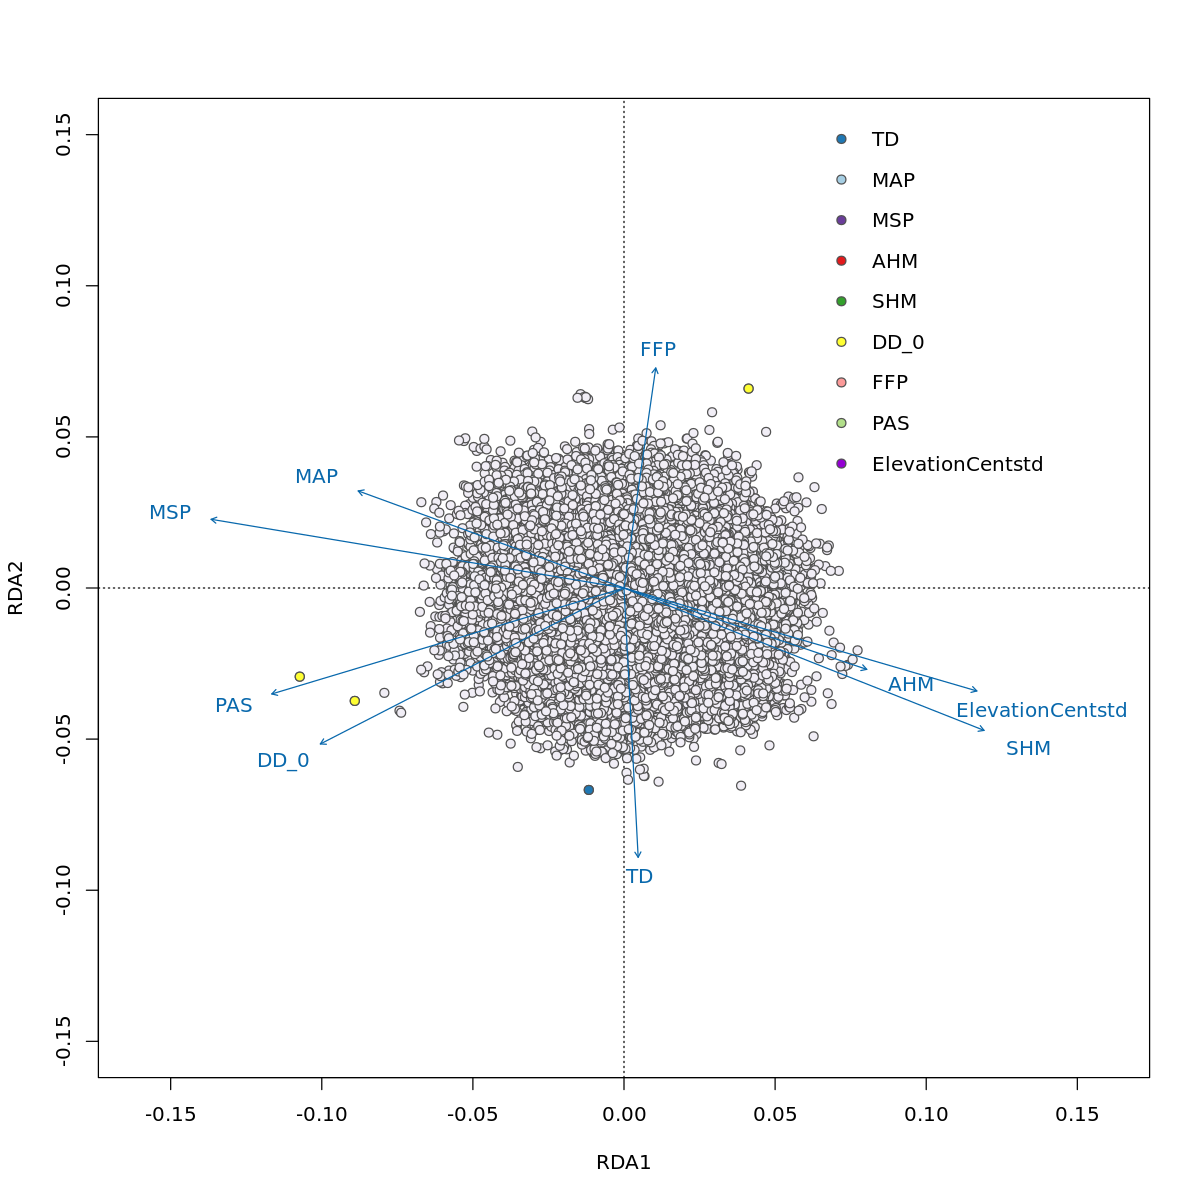

In [24]:
z7.cand <- plot_candidates(coastal_rda, save=FALSE, z=7)

In [27]:
table(z4.cand$predictor)


DD_0   TD 
   3    1 

03:02:50.231 : Reducing candidates to z>=4 ...

03:02:50.251 : Assinging colors to environments ...

03:02:50.255 : Assinging colors to SNPs ...



[1]    5663 2254116
revert_col.pred
   #1f78b4    #33a02c    #6a3d9a    #a6cee3    #b2df8a    #e31a1c    #f1eef6 
      1110        907       1571         23        444          9    2248453 
   #fb9a99    #ffff33 darkviolet 
       485        590        524 


03:02:53.087 : Generating figure display ...



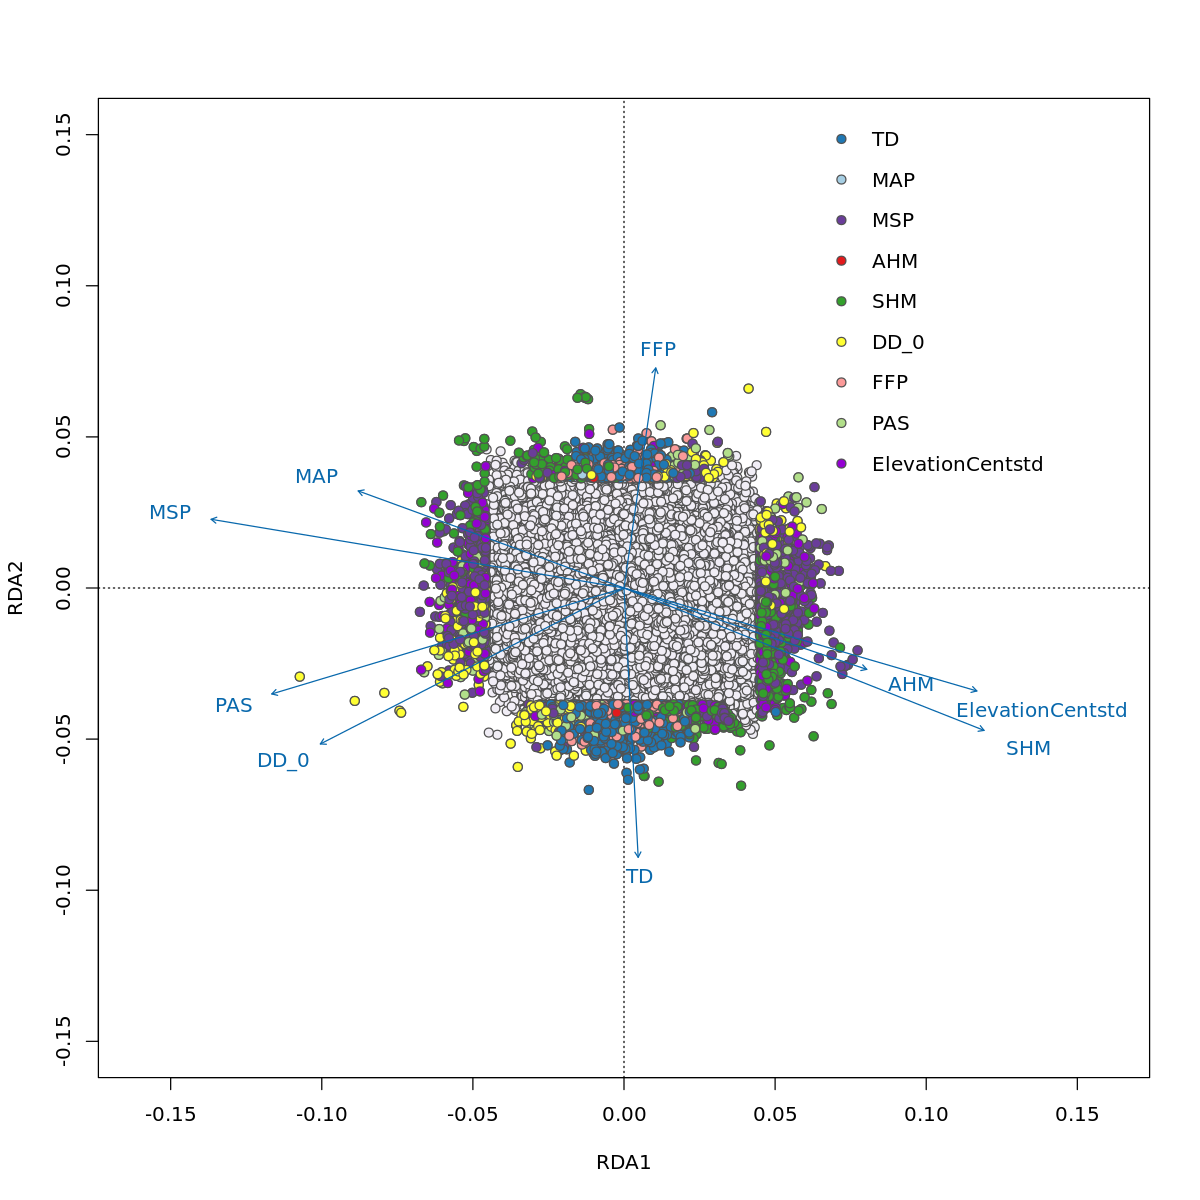

In [25]:
z4.cand <- plot_candidates(coastal_rda, save=FALSE, z=4)

In [26]:
# coastal
table(z4.cand$predictor)


             AHM             DD_0 ElevationCentstd              FFP 
               9              590              524              485 
             MAP              MSP              PAS              SHM 
              23             1571              444              907 
              TD 
            1110 

03:24:20.432 : Keeping all candidate snps ...

03:24:20.435 : Assinging colors to environments ...

03:24:20.460 : Assinging colors to SNPs ...



[1]  110487 2254116
revert_col.pred
   #1f78b4    #33a02c    #6a3d9a    #a6cee3    #b2df8a    #e31a1c    #f1eef6 
     15383      16489      26149       1136      13081        941    2143629 
   #fb9a99    #ffff33 darkviolet 
      8481      15001      13826 


03:24:23.599 : Saving figure to 
	/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/rda/RDA_coastal_9-vars_ax1-2_outliers-z2p5.pdf ...

03:25:47.131 : Generating figure display ...



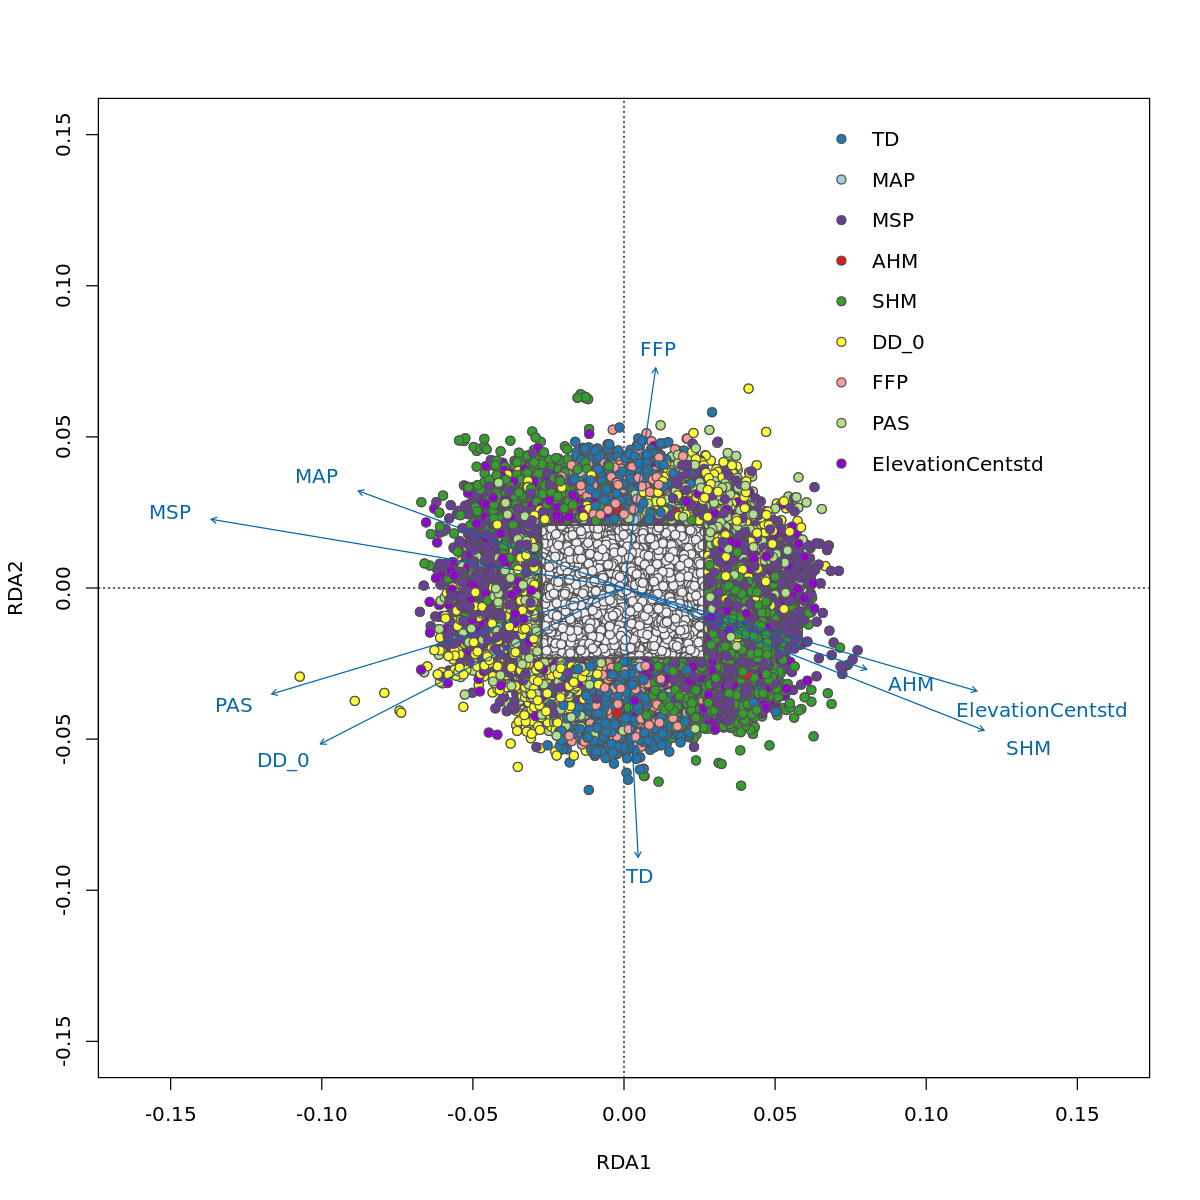

In [32]:
# plot all outliers (z>=2.5)
# use output from plot_candidates below to save info for all feasible outliers
figfile = paste(rdadir, 'RDA_coastal_9-vars_ax1-2_outliers-z2p5.pdf', sep='/')
.cand <- plot_candidates(coastal_rda, figfile=figfile)

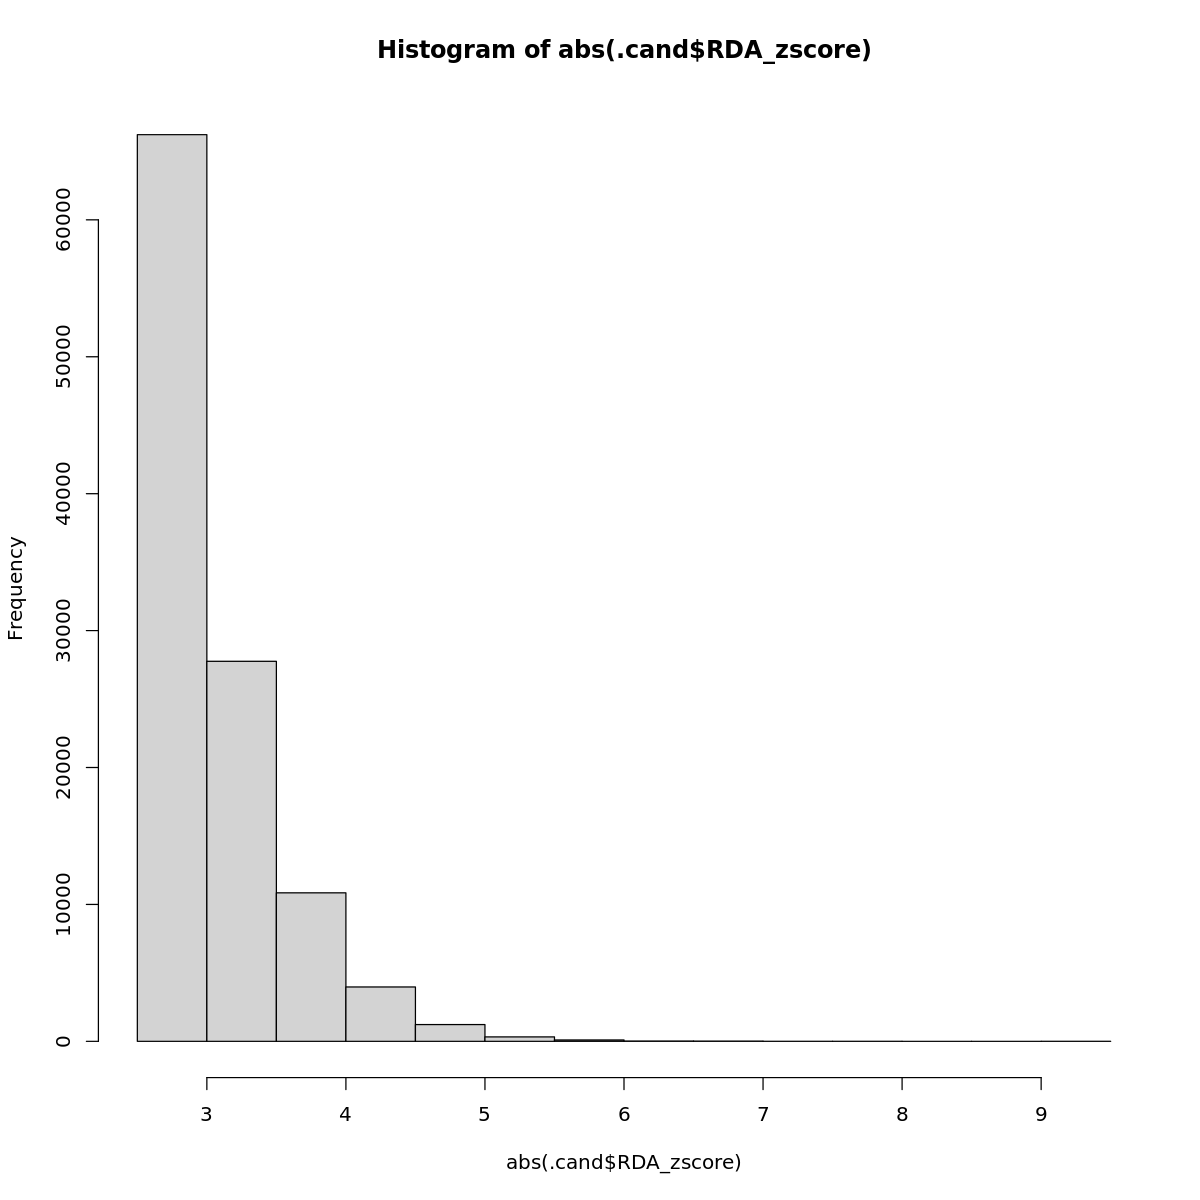

In [33]:
hist(abs(.cand$RDA_zscore))

In [34]:
saveRDS(reorder_col.pred, paste(rdadir, 'reorder_col.pred.RDS', sep='/'))
saveRDS(revert_col.pred, paste(rdadir, 'revert_col.pred.RDS', sep='/'))
saveRDS(empty.outline, paste(rdadir, 'empty.outline.RDS', sep='/'))
saveRDS(empty, paste(rdadir, 'empty.RDS', sep='/'))

In [35]:
write.table(.cand, candidate_file, sep='\t', row.names=F)

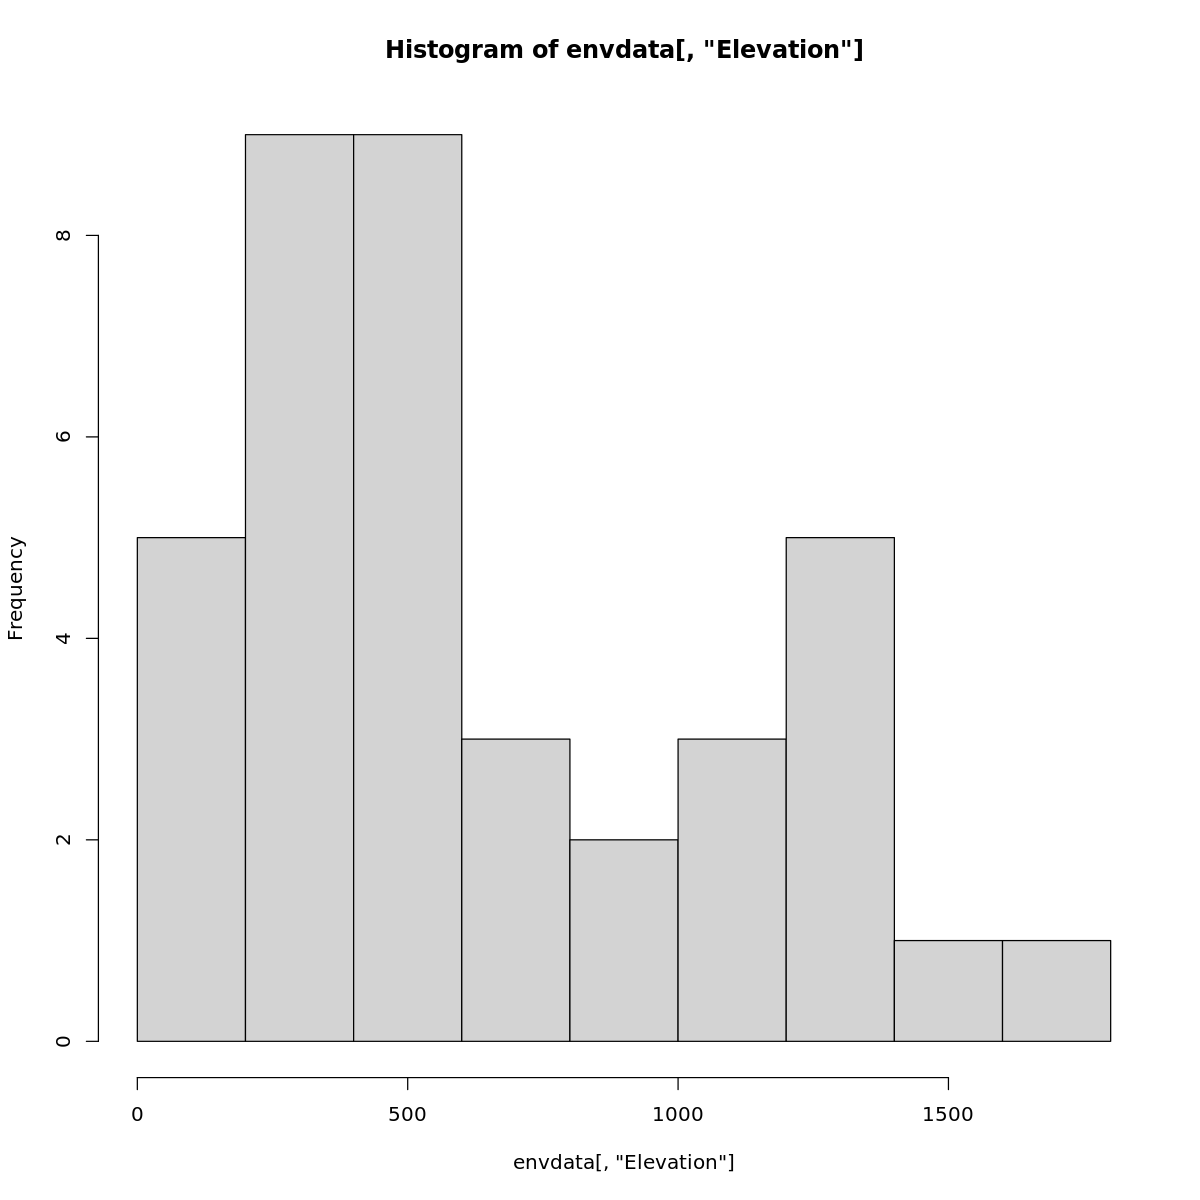

In [36]:
hist(envdata[,'Elevation'])

In [19]:
range(envdata[,'Elevation'])

[1]   61 1676

In [17]:
.cand <- read.table(candidate_file, header=T)
head(.cand)

,RDA_score,RDA_zscore,axis,snp,locus,TD,MAP,MSP,AHM,SHM,DD_0,FFP,PAS,ElevationCentstd,predictor,correlation,env_color
,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,-0.018173434725295499470,-2.7583243099352001693,1,jcf7190000000004-54857,jcf7190000000004-54857,0.1363540110688220008406,0.181314476343822000848,0.30818019825404702194,-0.206699109935280012085,-0.30827017614973201143,0.46990740436664202306,-0.071261688006405393692,0.39476670542345398962,-0.38963526429319800259,DD_0,0.46990740436664202306,#ffff33
2,-0.019312709323778098902,-2.9335546547297099984,1,jcf7190000000004-55975,jcf7190000000004-55975,0.0804849774531239958719,0.259606145348854011612,0.44827830020540399003,-0.274872762428621020270,-0.41019797093192000847,0.43883714516757599267,-0.075815860199717893808,0.45996871963621499546,-0.44212400842445498395,PAS,0.45996871963621499546,#b2df8a
3,-0.017399713686076300617,-2.6393192828260700900,1,jcf7190000000004-56338,jcf7190000000004-56338,0.2152230180601990006117,0.147944564529933986208,0.31084471515766498584,-0.182498949416699002279,-0.27167153117859499378,0.53429037725814099158,-0.252203446510290973936,0.48540392460620201964,-0.15890668968300300512,DD_0,0.53429037725814099158,#ffff33
4,0.016456437274643700985,2.5680512792526100085,1,jcf7190000000004-56472,jcf7190000000004-56472,0.0041220973068863296304,-0.314920658627844018973,-0.45383690998119302629,0.289377766077181020066,0.49681750331202501059,-0.35232121637906599343,0.127648758739207002222,-0.44493090818360997440,0.35506501054420902541,SHM,0.49681750331202501059,#33a02c
5,-0.017031333241756898417,-2.5826591656255097895,1,jcf7190000000004-57312,jcf7190000000004-57312,0.1451168936498359873788,0.197684566810146011839,0.30465162080170599124,-0.218355196621559999315,-0.36343490911672099442,0.42428469683961500536,-0.166506856405785996778,0.34149891323282999256,-0.34210028072312198555,DD_0,0.42428469683961500536,#ffff33
6,-0.016714914289720498447,-2.5339911779966302063,1,jcf7190000000004-136878,jcf7190000000004-136878,0.3762893135957779966461,0.054708421025174300278,0.13841218059441801058,-0.068319591464257603541,-0.11645169238920100030,0.43348832166944800681,-0.099754836946340699755,0.29839682459059202468,-0.18743798245770801336,DD_0,0.43348832166944800681,#ffff33


In [18]:
table(.cand$predictor)


             AHM             DD_0 ElevationCentstd              FFP 
             941            15001            13826             8481 
             MAP              MSP              PAS              SHM 
            1136            26149            13081            16489 
              TD 
           15383 